# Data Science Class Project (100 points)

Due May 13, 11:59pm 

Turn in one html file on collab the same way you have done for the exam and homework assignments.

# Name: Mohan Shankar

# Project Title: Predicting Aggregation Properties in a Self-Assembling System

## Introduction: (15 points)

Please make sure your introduction includes the following information:

* Motivation: Why you chose this topic and dataset. (5)
* Dataset:  Where you obtained the dataset and the information it contains. (5)
* Goal(s): What are the goals of your project? (5)

Active matter is defined as something that is able to take energy from its enviroment in order to drive itself away from equilibirum. Large scale behavior emerges from collective self-organization, leading to novel phenomena such as nonequilibrium phase transitions and collective directed motion in the case of systems containing such matter. As a result of this, numerous studies of the physics surrounding these systems have cropped up sue to possible, far-reaching utility that these systems offer [[1](#ref)]. Figure 1 below shows many such possibilities.


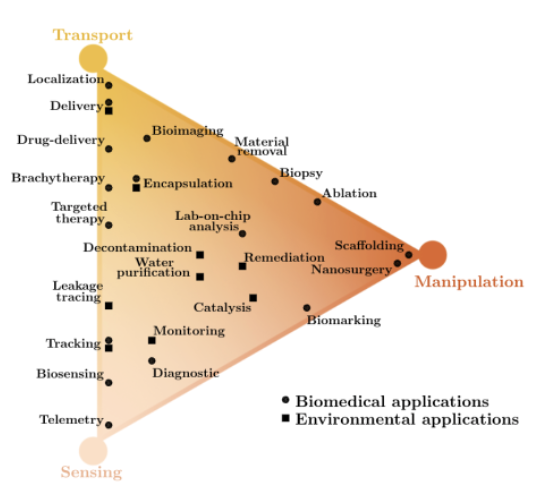

In [330]:
from IPython.display import display, Image

display(Image(filename="apm.png", height = 400, width = 400))

While I was in the Egorov Group, an active collaboration with the Likos Group of the University of Vienna saw the exploration of systems governed by a certain interatomic potential through molecular dynamics (MD) simulations in LAMMPS. In particular, we focused on the GEM-n potential which belongs to a class of isotropic, density-independent pair potentials, $\phi (\mathbf{r}) = \phi (r)$ where $|\mathbf{r}| = r$ is the inter-particle distance. The general form can be expressed as

$ \begin{equation}  \phi (r) = \varepsilon e^{- \left( \frac{r}{\sigma} \right)^n} \end{equation}$

where $\varepsilon$ and $\sigma$ are energy and length scales respectively. These parameters are employed here (and in general) to ensure the potential can be applied to a variety of systems. The potential is fascinating due to the formation of clusters in a liquid phase solely through entropic considerations when n > 2, making it an attractive option for self-assembly and a general description of active matter. An example of this aggregation is shown in Fig. 2 where a two-compoenent system of GEM-2 and GEM-4 particles results in clustering of the GEM-4 species, effectively trapping the GEM-2 particles.

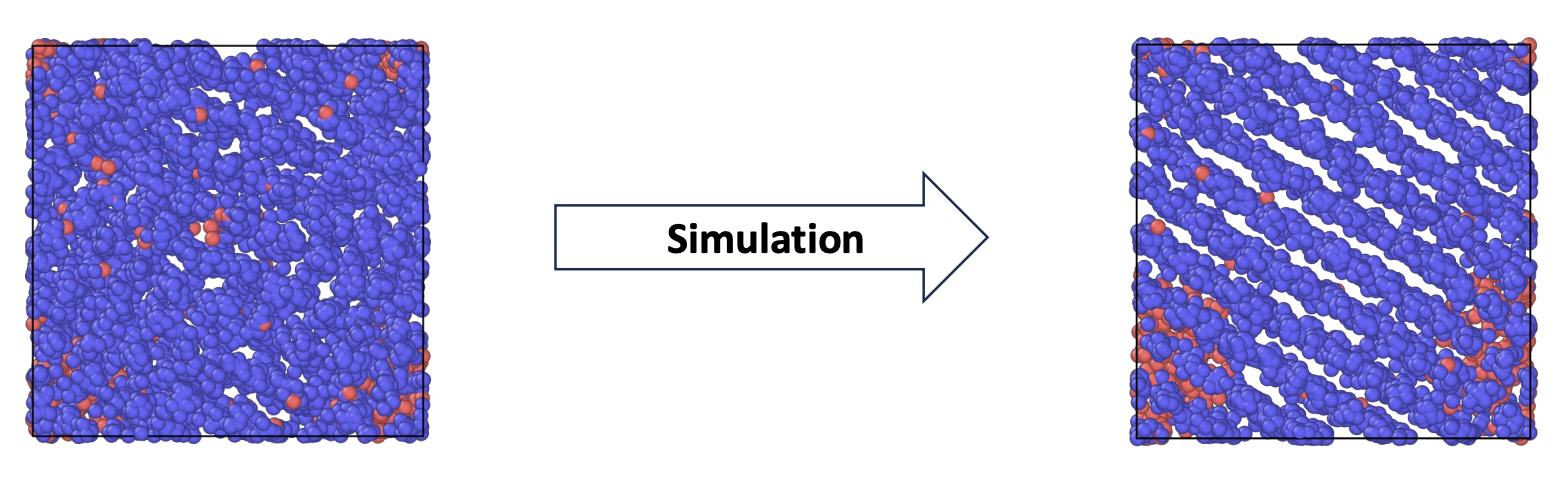

In [333]:
display(Image(filename="two_comp.png", height = 800, width = 800))

Of interest is a dimer system consisting of a GEM-2 and GEM-4 particle, shown below in Fig. 3. 

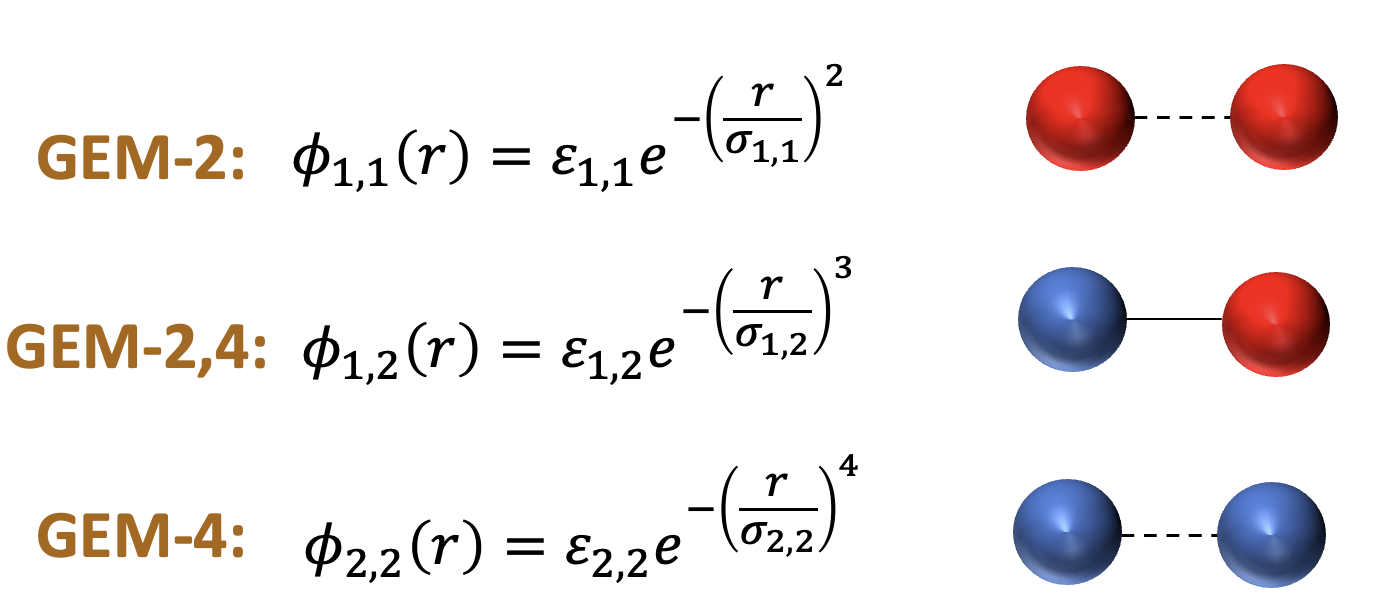

In [247]:
display(Image(filename="dimer.png", height = 700, width = 700))

Here, the spheres represent coarse-grained dendrimers, manufactured polymers that have wide utility in drug delivery, which behave following the GEM-n potential. Only the Type I and Type II particles have a harmonic bond of length $r / \sigma$ = 0.5 between them, but there are three sets of interaction that have to be defined. Strictly speaking, the dataset for this project will come from analyzing LAMMPS trajectory files (generated through simulation) which contain particle positions and velocities for each frame using the OVITO Python library [[2](#ref)]. In particular, I found  the number and size of clusters characterized by a cutoff distance of $r/ \sigma $ = 0.4 due to it being slightly shorter than the designated bond length for a given frame in the simulation.

With this in mind, the goal of this project is to better understand the conditions under which clusters form as well as their geometry given the set of specified features as it could offer useful insight to give back to the Group, creating a new avenue of exploration for future work.

## Methods: (15 Points) 

Briefly describe:

* What are the methods you will use? (5)
* Justify why you chose these methods for your particular data set. (5)
* What are the free parameters and hyperparameters in those methods and how will you choose and/or optimize them? (5)

In order to generate the data from the LAMMPS trajectory files, the `cluster analysis` feature of the OVITO Python library was implemented in order to characterize the number of clusters and their size. A visualization of this is shown below in Fig. 4 where the different colors denote distinct clusters.

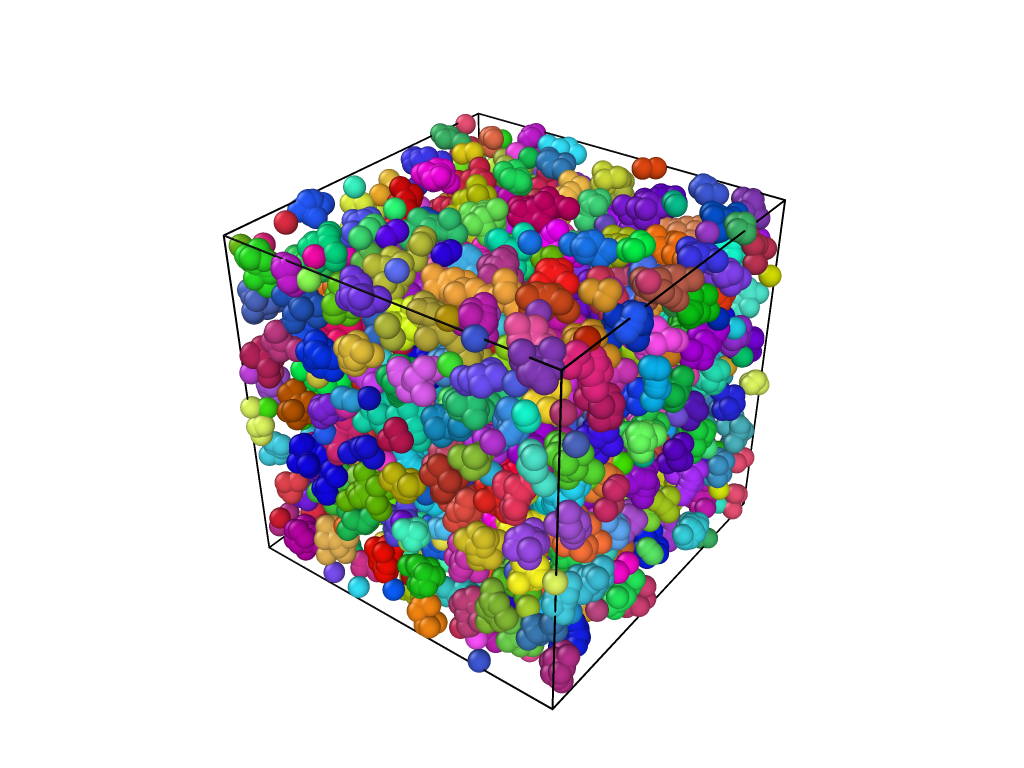

In [261]:
display(Image(filename="cluster.png", height = 600, width = 600))

In addition to OVITO calculating the number and size of clusters, it is also able to produce a gyration tensor for each cluster. Defined as

$$ S = \begin{bmatrix} 
s_{xx} & s_{xy} & s_{xz} \\
s_{yx} & s_{yy} & s_{yz} \\
s_{zx} & s_{zy} & s_{zz} 
\end{bmatrix} \, .$$
OVITO returns the `xx`, `yy`, `zz`, `xy`, `xz`, and `yz` components which the tensor can be constructed from, and the eigenvalues of this matrix can be used to calculate the asphericity paramter,

$$ b = \lambda_1 - \frac{1}{2} (\lambda_2 + \lambda_3) \, , $$

defined such that $\lambda_1 \geq \lambda_2 \geq \lambda_3$ with the interpretation that increasing b indicates greater deviation from the shape of a sphere [[3](#ref)]. 

Given the continuous nature of the data, regression seemed to be the more appropriate class of techniques to apply in order to better understand the system at hand. In particular, I will implement linear regression coupled with feature engineering, GPR, and KRR. GPR requires specification of one hyperparameter $\alpha$ while KRR requires two $\alpha$ and $\gamma$, each of which can be optimized by implementing GridSearchCV in conjuction with the two techniques. Regarding linear regression, partial least squares regression and LASSO were used to prune extraneous features, reducing the dimensionality of the data while still ensuring effective performance. In addition to dimensionality reduction, LASSO sheds insight on *which* features are superfluous, providing insight to the system at hand.

Finally, I crafted a simple classification model to see which technique between SVM, decision tree, and kNN best works to find a system with a "high" sphere to non-sphere ratio. In each case, their hyperparameters ({c, $\gamma$}, {max depth}, and {k}) were tuned using GridSearch.

## Results: (55 points)
Report your results using primarily tables, figures, and text blocks that describe them.  Label axis, units, and legends. Include all code used to generate the figures and tables.  Make sure you clearly state what you did to generate the data in each figure/table.

* Analysis of data. (40)
* Figure quality. (15)

In [249]:
#-------------------------------------------------------------------------------- */
# Import dependencies 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [250]:
#-------------------------------------------------------------------------------- */
# Define range of parameters to iterate through in my directory

# have to hand-type these because the floating point precision makes it slightly off if I use np.linspace or np.arange

epsilon = np.array([0.1,0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
density = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5])

number_clusters = np.zeros((len(epsilon), len(density))) # make a matrix where epsilon is constant across a row and increases down a column
size_clusters = np.zeros((len(epsilon), len(density))) # make a matrix where epsilon is constant across a row and increases down a column
sphere_ratio = np.zeros((len(epsilon), len(density))) # make a matrix of sphere vs. non-sphere ratio

In [262]:
#-------------------------------------------------------------------------------- */
# Calculate cluster number, cluster size, and sphere:non-sphere ratio while time averaging

from ovito.io import import_file
from ovito.modifiers import ClusterAnalysisModifier

loop_over = 25 # average over first 25 frames for the sake of my laptop and because the results don't change appreciably beyond it

# iterate through each epsilon and density that the simulations were ran over

for i, eps in enumerate(epsilon):
    print("Eps", eps) # print epsilon for some progress indicator 
    for j, rho in enumerate(density):
        
        pipeline = import_file("/Users/mohan/Desktop/UVA/Y4S2/Chem_DS/project/data2/eps_"+str(eps)+"/"+str(rho)+"/dump.lammpstrj")

        time_avg_number = np.zeros((loop_over))

        time_avg_size = np.zeros((loop_over))

        ratio_asphere = np.zeros((loop_over))

        for specific_frame in range(loop_over): # time average here

            frame_number = specific_frame # loop thru each frame of simulation data

            # Perform cluster analysis on the specified frame
            pipeline.modifiers.append(ClusterAnalysisModifier(
                cutoff=0.4,  # Specify desired cutoff range 
                sort_by_size=True, 
                compute_com=True,
                compute_gyration = True))

            # Compute the pipeline with the specified frame number
            data = pipeline.compute(frame=frame_number)

            cluster_table = data.tables['clusters']

            nc = cluster_table['Cluster Identifier'][...] # grab number of clusters

            sc = cluster_table['Cluster Size'][...] # grab size of clusters

            new = np.hstack((sc.reshape(-1, 1), nc.reshape(-1, 1)))

            pre_filter = pd.DataFrame({'Size': new[:, 0], 'Number': new[:, 1]}) # create data frame with number and size in order to filter the results

            filtered_data = pre_filter[pre_filter['Size'] >= 2] # remove all "clusters" whose size is less than 2

            asphericity = [] # house asphericity value for each cluster in a given frame

            for cluster in range(max(filtered_data.iloc[:, 1])): # iterate over all clusters whose size > 1 and find asphericity parameter for a given simulation frame
                
                T = cluster_table['Gyration Tensor'][cluster] # grab specific cluster and create gyration tensor

                xx = T[0]

                yy = T[1]

                zz = T[2]

                xy = yx = T[3]

                xz = zx = T[4]

                zy = yz = T[5]

                tensor = np.array([xx, xy, xz, yx, yy, yz, zx, zy, zz]).reshape(3,3) # create Gyration tensor

                vals, vecs = np.linalg.eigh(tensor) # technically the matrix is Hermitian

                lxx, lyy, lzz = np.sort(vals)[0], np.sort(vals)[1], np.sort(vals)[2] # sort eigenvalues in ascending order (i.e. lzz is the largest value)

                b = lzz - 0.5*(lxx + lyy) # fnid asphericity for a given cluster 

                asphericity.append(b)

            num_spheres = sum(1 for value in asphericity if value < 0.05) # generator expression to find number of elements below cutoff to designate them as a sphere; cutoff chosen through visual inspection 

            ratio_asphere[specific_frame] = num_spheres/len(asphericity) # append percent of spheres to array housing frame-by-frame data 

            time_avg_size[specific_frame] = np.mean(filtered_data.iloc[:, 0]) # append average cluster size of a particular frame to frame-by-frame array

            time_avg_number[specific_frame] = max(filtered_data.iloc[:, 1]) # append number of clusters in a particular frame to frame-by-frame array

        number_clusters[i][j] = np.mean(time_avg_number) # average cluster number over time

        size_clusters[i][j] = np.mean(time_avg_size) # average cluster size over time

        sphere_ratio[i][j] = np.mean(ratio_asphere)  # average sphere percentage over time

Eps 0.1
Eps 0.15
Eps 0.2
Eps 0.25
Eps 0.3
Eps 0.35
Eps 0.4
Eps 0.45
Eps 0.5
Eps 0.55
Eps 0.6
Eps 0.65
Eps 0.7
Eps 0.75
Eps 0.8
Eps 0.85
Eps 0.9
Eps 0.95
Eps 1.0


In [377]:
#-------------------------------------------------------------------------------- */
# Create dataframe

print((np.tile(density, len(epsilon)).reshape(-1, 1)).shape)
print((np.repeat(epsilon, len(density)).reshape(-1, 1)).shape)

results = np.hstack((np.repeat(epsilon, len(density)).reshape(-1, 1), np.sqrt(np.repeat(epsilon, len(density)).reshape(-1, 1)), np.tile(density, len(epsilon)).reshape(-1, 1), number_clusters.reshape(-1, 1), size_clusters.reshape(-1, 1), sphere_ratio.reshape(-1, 1)))
df = pd.DataFrame({'Eps11': results[:, 0], 'Eps12': results[:, 1], 'Density': results[:, 2], 'Number of Clusters': results[:, 3], 'Size of Clusters': results[:, 4], 'Sphere Percent': results[:, -1]})
# df.to_csv('dimer_data.csv', index=False)  # save data 

(399, 1)
(399, 1)


In [275]:
df.max() # find max value for each parameter/output 

Eps11                   1.000000
Eps12                   1.000000
Density                 4.500000
Number of Clusters    919.160000
Size of Clusters       18.459953
Sphere Percent          0.982180
dtype: float64

In [310]:
df.nlargest(10, ['Size of Clusters']) 

Eps11     Eps12  Density  Number of Clusters  Size of Clusters  \
377   0.95  0.974679      4.5              482.28         18.459953   
314   0.80  0.894427      4.5              483.72         18.379733   
335   0.85  0.921954      4.5              486.76         18.241411   
356   0.90  0.948683      4.5              489.00         18.194810   
20    0.10  0.316228      4.5              489.04         18.193521   
398   1.00  1.000000      4.5              489.04         18.193521   
272   0.70  0.836660      4.5              488.76         18.102701   
251   0.65  0.806226      4.5              488.60         18.099344   
293   0.75  0.866025      4.5              492.48         17.994475   
230   0.60  0.774597      4.5              493.56         17.873865   

     Sphere Percent  
377        0.770400  
314        0.769082  
335        0.772224  
356        0.778582  
20         0.777830  
398        0.777830  
272        0.755403  
251        0.750394  
293        0.759115  
230        0.751854

In [313]:
df.nsmallest(10, ['Size of Clusters']) 

Eps11     Eps12  Density  Number of Clusters  Size of Clusters  \
0     0.10  0.316228      0.5               46.76          2.152866   
378   1.00  1.000000      0.5               46.76          2.152866   
315   0.85  0.921954      0.5               48.48          2.155928   
357   0.95  0.974679      0.5               48.08          2.163727   
168   0.50  0.707107      0.5               52.24          2.167976   
231   0.65  0.806226      0.5               50.52          2.170185   
147   0.45  0.670820      0.5               53.12          2.170946   
336   0.90  0.948683      0.5               48.92          2.171019   
210   0.60  0.774597      0.5               52.36          2.171954   
105   0.35  0.591608      0.5               53.56          2.172710   

     Sphere Percent  
0          0.981232  
378        0.981232  
315        0.973899  
357        0.973857  
168        0.971143  
231        0.971443  
147        0.972157  
336        0.972715  
210        0.980013  
105        0.982180

In [311]:
df.nlargest(10, ['Number of Clusters']) 

Eps11     Eps12  Density  Number of Clusters  Size of Clusters  \
25    0.15  0.387298      2.5              919.16          4.070179   
46    0.20  0.447214      2.5              915.24          4.097176   
109   0.35  0.591608      2.5              901.16          4.207914   
67    0.25  0.500000      2.5              900.68          4.177836   
88    0.30  0.547723      2.5              898.88          4.214296   
151   0.45  0.670820      2.5              893.12          4.277383   
130   0.40  0.632456      2.5              891.00          4.288057   
193   0.55  0.741620      2.5              884.04          4.386485   
172   0.50  0.707107      2.5              881.12          4.364107   
214   0.60  0.774597      2.5              879.44          4.402739   

     Sphere Percent  
25         0.725602  
46         0.724229  
109        0.716561  
67         0.717267  
88         0.724614  
151        0.713866  
130        0.714659  
193        0.713572  
172        0.712496  
214        0.713873

In [314]:
df.nsmallest(10, ['Number of Clusters']) 

Eps11     Eps12  Density  Number of Clusters  Size of Clusters  \
0     0.10  0.316228      0.5               46.76          2.152866   
378   1.00  1.000000      0.5               46.76          2.152866   
357   0.95  0.974679      0.5               48.08          2.163727   
315   0.85  0.921954      0.5               48.48          2.155928   
336   0.90  0.948683      0.5               48.92          2.171019   
294   0.80  0.894427      0.5               48.96          2.186655   
273   0.75  0.866025      0.5               50.28          2.181463   
252   0.70  0.836660      0.5               50.48          2.180422   
231   0.65  0.806226      0.5               50.52          2.170185   
189   0.55  0.741620      0.5               50.88          2.234861   

     Sphere Percent  
0          0.981232  
378        0.981232  
357        0.973857  
315        0.973899  
336        0.972715  
294        0.960989  
273        0.959991  
252        0.970163  
231        0.971443  
189        0.961595

In [312]:
df.nlargest(10, ['Sphere Percent']) 

Eps11     Eps12  Density  Number of Clusters  Size of Clusters  \
105   0.35  0.591608      0.5               53.56          2.172710   
0     0.10  0.316228      0.5               46.76          2.152866   
378   1.00  1.000000      0.5               46.76          2.152866   
210   0.60  0.774597      0.5               52.36          2.171954   
315   0.85  0.921954      0.5               48.48          2.155928   
357   0.95  0.974679      0.5               48.08          2.163727   
336   0.90  0.948683      0.5               48.92          2.171019   
147   0.45  0.670820      0.5               53.12          2.170946   
126   0.40  0.632456      0.5               55.92          2.183188   
231   0.65  0.806226      0.5               50.52          2.170185   

     Sphere Percent  
105        0.982180  
0          0.981232  
378        0.981232  
210        0.980013  
315        0.973899  
357        0.973857  
336        0.972715  
147        0.972157  
126        0.972039  
231        0.971443

In [315]:
df.nsmallest(10, ['Sphere Percent']) 

Eps11     Eps12  Density  Number of Clusters  Size of Clusters  \
29   0.15  0.387298      3.3              726.12          8.184948   
28   0.15  0.387298      3.2              761.00          7.383217   
32   0.15  0.387298      3.6              648.72         10.318804   
50   0.20  0.447214      3.3              718.52          8.329183   
49   0.20  0.447214      3.2              749.36          7.562773   
71   0.25  0.500000      3.3              685.88          8.862013   
30   0.15  0.387298      3.4              694.60          8.925235   
27   0.15  0.387298      3.1              807.12          6.617124   
51   0.20  0.447214      3.4              674.64          9.318080   
53   0.20  0.447214      3.6              627.16         10.819297   

    Sphere Percent  
29        0.619808  
28        0.619901  
32        0.622846  
50        0.623506  
49        0.625361  
71        0.628345  
30        0.629177  
27        0.629407  
51        0.630871  
53        0.631083

Upon preliminary analysis of the data, the largest average cluster sizes are consistently formed at the highest density for each case of $\varepsilon_{1,1}$ which makes intuitive sense as only half the particles are governed by the GEM-4 potential and thus able to cluster. Since there are an equal amount of GEM-2 and GEM-4 particles, number of GEM-4 particles is a monotonically increasing function of density, justifying the trend. Number of clusters doesn't appear to lie at any extreme considering the maximum values occur at $\rho$ = 2.5, lying in the middle of the set of densities. Returning back to a discernible trend, the ratio of sphere to non-spherical clusters is greatest at the *lowest* density while varying the energy scale. Furthermore, there seems to be a positive correlation between sphere percentage and cluster size as smaller clusters are more spherical.

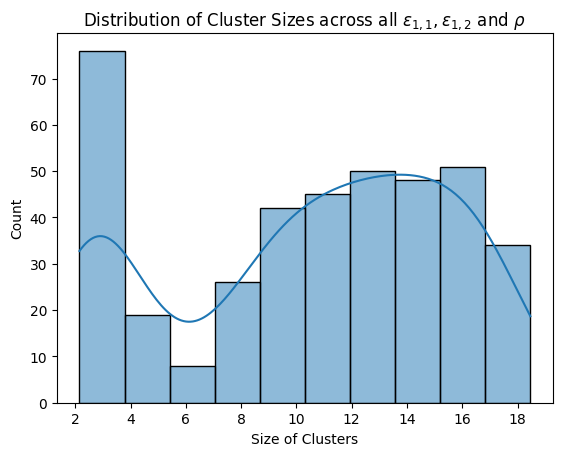

In [279]:
sns.histplot(data=df, x="Size of Clusters", kde = True).set(title = r"Distribution of Cluster Sizes across all $\varepsilon_{1,1}, \varepsilon_{1,2}$ and $\rho$")
plt.show();

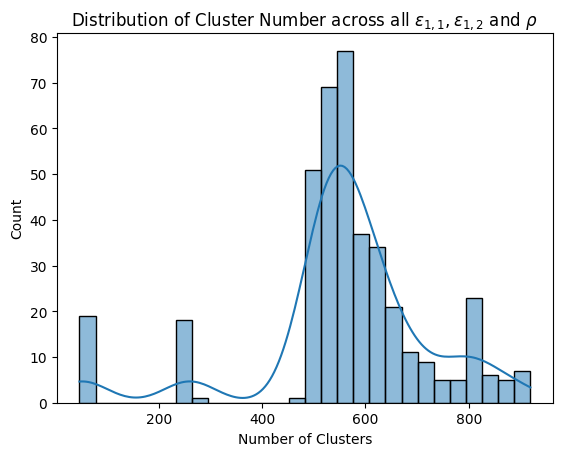

In [280]:
sns.histplot(data=df, x="Number of Clusters", kde = True).set(title = r"Distribution of Cluster Number across all $\varepsilon_{1,1}, \varepsilon_{1,2}$ and $\rho$")
plt.show();

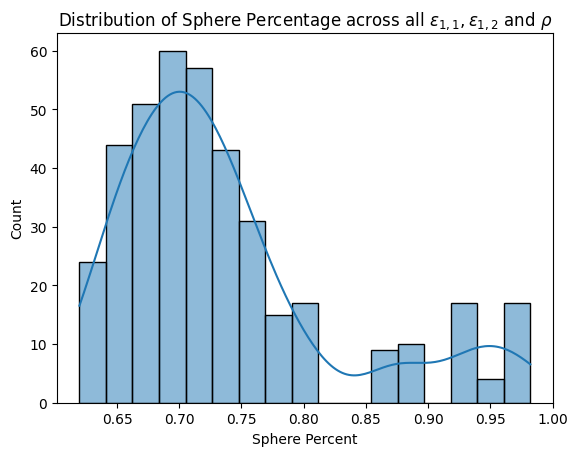

In [281]:
sns.histplot(data=df, x="Sphere Percent", kde = True).set(title = r"Distribution of Sphere Percentage across all $\varepsilon_{1,1}, \varepsilon_{1,2}$ and $\rho$")
plt.show();

Plotting histograms of each charactertistic of interest does not reveal anything particularly clear as each value seems bimodal and/or having some sort of skew. Beginning implementation of regression techniques, a baseline linear model was created.

r^2 Number of Clusters: 0.18050637574478412
r^2 Size of Clusters: 0.9005826709104761
r^2 Percent Spheres: 0.5637783938200889


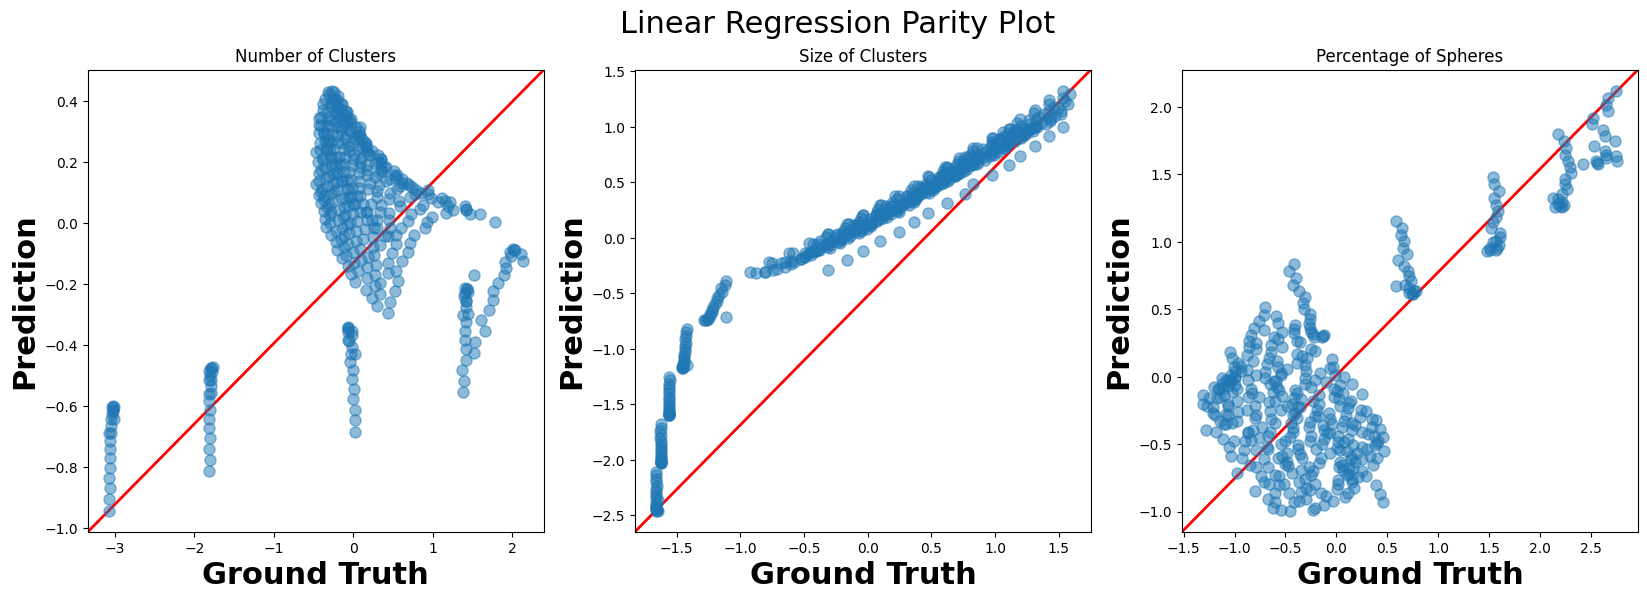

In [317]:
#-------------------------------------------------------------------------------- */
# Create baseline linear model for the three values of interest

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

x = df.iloc[:, 0:3]

x_scaled = (x - x.mean(axis=0))/x.std(axis=0)  

nc = df['Number of Clusters'].values

nc_scaled = (nc - nc.mean(axis=0))/nc.std(axis=0)  

sc = df['Size of Clusters'].values

sc_scaled = (sc - sc.mean(axis=0))/sc.std(axis=0)  

sr = df['Sphere Percent'].values

sr_scaled = (sr - sr.mean(axis=0))/sr.std(axis=0)  

x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x_scaled, sc_scaled, test_size=0.3)
x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(x_scaled, nc_scaled, test_size=0.3)
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x_scaled, sr_scaled, test_size=0.3)

linear_model = LinearRegression(fit_intercept=True) # create a linear regression model 
linear_model.fit(x_train_n, y_train_n) 
r2_nc = linear_model.score(x_test_n, y_test_n) 

yhat_nc = linear_model.predict(x_scaled) # create the model prediction for all x values

linear_model.fit(x_train_s, y_train_s) 
r2_sc = linear_model.score(x_test_s, y_test_s) 

yhat_sc = linear_model.predict(x_scaled) #create the model prediction for all x values

linear_model.fit(x_train_r, y_train_r) # fit the model
r2_sr = linear_model.score(x_test_r, y_test_r) # get the "score", which is equivalent to r^2

yhat_sr = linear_model.predict(x_scaled) #create the model prediction

print("r^2 Number of Clusters:", r2_nc)
print("r^2 Size of Clusters:", r2_sc)
print("r^2 Percent Spheres:", r2_sr)

#-------------------------------------------------------------------------------- */
# PLOT

font_axis_publish = {'color':  'black', 'weight': 'bold', 'size': 22}


fig, ax = plt.subplots(1, 3, figsize = (20, 6))

ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
# ax[0].plot(x, y1, "o", alpha=0.5 , ms=8)
ax[0].plot(nc_scaled, yhat_nc, "o", alpha=0.5 , ms=8)
ax[0].set_title("Number of Clusters")
ax[0].set_xlabel('Ground Truth', fontdict=font_axis_publish)
ax[0].set_ylabel('Prediction', fontdict=font_axis_publish)

ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot(sc_scaled, yhat_sc, "o", alpha=0.5 , ms=8)
ax[1].set_title("Size of Clusters")
ax[1].set_xlabel('Ground Truth', fontdict=font_axis_publish)
ax[1].set_ylabel('Prediction', fontdict=font_axis_publish)
fig.suptitle("Linear Regression Parity Plot", fontsize = 22)

ax[2].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[2].transAxes)
ax[2].plot(sr_scaled, yhat_sr, "o", alpha=0.5 , ms=8)
ax[2].set_title("Percentage of Spheres")
ax[2].set_xlabel('Ground Truth', fontdict=font_axis_publish)
ax[2].set_ylabel('Prediction', fontdict=font_axis_publish)
fig.suptitle("Linear Regression Parity Plot", fontsize = 22)
plt.show();


Here we see that a nascent model does a good job of capturing cluster size with an $r^2$ of 0.90, but cluster number and sphere percentage is more elusive. Given the sparse nature of the data in the way of input parameters, feature engineering was implmented in order to create a wider variety of data for the linear model to train on.

In [283]:
from autofeat import AutoFeatRegressor

feat_model = AutoFeatRegressor(verbose=0, feateng_steps=3, featsel_runs=1)

x_new_nc = feat_model.fit_transform(x_scaled, nc_scaled) # new set of features for number clusters 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


In [284]:

r2_newfeat_nc_train = feat_model.score(x_train_n, y_train_n)

r2_newfeat_nc_test = feat_model.score(x_test_n, y_test_n)


print("r^2 Testing Results for new Features regarding cluster #:", r2_newfeat_nc_train)
print("r^2 Testing Results for new Features regarding cluster #:", r2_newfeat_nc_test)

x_new_nc

r^2 Testing Results for new Features regarding cluster #: 0.972182760795915
r^2 Testing Results for new Features regarding cluster #: 0.9645155886584976


Eps11     Eps12   Density    Density**15  Abs(Density)/Density  \
0   -1.641107 -1.979896 -2.475387 -802874.020797                  -1.0   
1   -1.641107 -1.979896 -2.019395  -37872.054330                  -1.0   
2   -1.641107 -1.979896 -1.563403    -814.820753                  -1.0   
3   -1.641107 -1.979896 -1.107410      -4.619844                  -1.0   
4   -1.641107 -1.979896 -0.651418      -0.001614                  -1.0   
..        ...       ...       ...            ...                   ...   
394  1.641107  1.423858  0.807758       0.040665                   1.0   
395  1.641107  1.423858  0.898956       0.202339                   1.0   
396  1.641107  1.423858  0.990155       0.862079                   1.0   
397  1.641107  1.423858  1.081353       3.232323                   1.0   
398  1.641107  1.423858  1.172552      10.888825                   1.0   

     exp(-Eps12**2 + Eps12)  Abs(Density + Eps11**2)  \
0                  0.002740                 0.217846   
1                  0.002740                 0.673838   
2                  0.002740                 1.129831   
3                  0.002740                 1.585823   
4                  0.002740                 2.041815   
..                      ...                      ...   
394                0.546887                 3.500991   
395                0.546887                 3.592190   
396                0.546887                 3.683388   
397                0.546887                 3.774586   
398                0.546887                 3.865785   

     exp(-Density**2 + Eps12)  1/(Density + exp(Eps12))  \
0                    0.000301                 -0.427843   
1                    0.002339                 -0.531544   
2                    0.011985                 -0.701597   
3                    0.040508                 -1.031644   
4                    0.090334                 -1.948049   
..                        ...                       ...   
394                  2.162759                  0.201578   
395                  1.851017                  0.197939   
396                  1.558075                  0.194429   
397                  1.289859                  0.191041   
398                  1.050199                  0.187770   

     1/(Eps12 + exp(Density))  ...  exp(-Density**2 + Eps12**2)  \
0                   -0.527491  ...                     0.109969   
1                   -0.541372  ...                     0.853876   
2                   -0.564821  ...                     4.374357   
3                   -0.606251  ...                    14.785247   
4                   -0.685594  ...                    32.971449   
..                        ...  ...                          ...   
394                  0.272722  ...                     3.954674   
395                  0.257672  ...                     3.384643   
396                  0.242983  ...                     2.848989   
397                  0.228701  ...                     2.358547   
398                  0.214865  ...                     1.920322   

     1/(Density**2 + exp(Eps11))  log(Eps11**2 + Abs(Density))  \
0                       0.158195                      1.642606   
1                       0.234098                      1.550246   
2                       0.379076                      1.448479   
3                       0.704165                      1.335170   
4                       1.617834                      1.207362   
..                           ...                           ...   
394                     0.172018                      1.253046   
395                     0.167532                      1.278762   
396                     0.162832                      1.303833   
397                     0.157973                      1.328291   
398                     0.153004                      1.352165   

     Abs(Eps11**2 - Abs(Density))  1/(Abs(Density) + 1/Density)  \
0                        0.217846                      0.482763   
1    

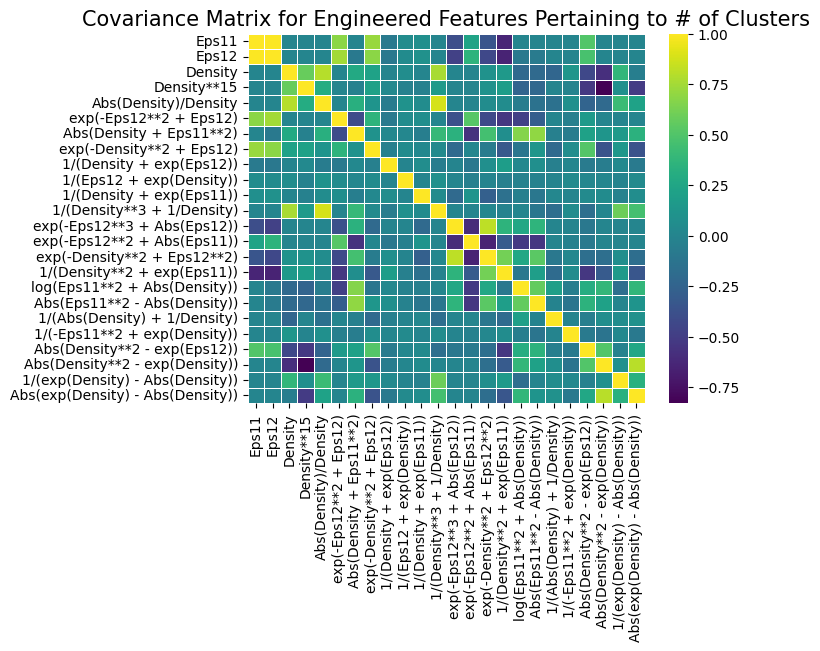

In [285]:
x_new_nc_scaled = x_new_nc.apply(lambda x: (x - x.mean()) / x.std(), axis=0) # standard scale each column of the data frame

sns.heatmap(x_new_nc_scaled.cov(), linewidth=.5, cmap = 'viridis')
plt.title("Covariance Matrix for Engineered Features Pertaining to # of Clusters", fontsize = 15)
plt.show();

For cluster number, 21 new features were generated after implementing three feature engineering steps. Considering the increase in $r^2$ from 0.18 to ~0.98 for both the train and test splits, the procedure appears to have worked well while benefitting from the simple nature of linear regression to avoid overfitting. Looking at the covariance matrix, much isn't revealed in the way of correlations as the features are most related to non-linear combinations of themselves with the outlier being $\varepsilon_{1,1}$ and $\varepsilon_{1,2}$ as the 1,2 energy scale is effectively an engineered feature of the 1,1 parameter.

In [286]:
x_new_sc = feat_model.fit_transform(x_scaled, sc_scaled) # new set of features for cluster size

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


In [287]:
r2_newfeat_sc_train= feat_model.score(x_train_s, y_train_s)

r2_newfeat_sc_test= feat_model.score(x_test_s, y_test_s)


print("r^2 Testing Results for new Features regarding cluster size:", r2_newfeat_sc_train)
print("r^2 Testing Results for new Features regarding cluster size:", r2_newfeat_sc_test)

x_new_sc

r^2 Testing Results for new Features regarding cluster size: 0.9988485676171809
r^2 Testing Results for new Features regarding cluster size: 0.9986932812533379


Eps11     Eps12   Density  exp(Density)  Density*exp(Eps12)  \
0   -1.641107 -1.979896 -2.475387      0.084130           -0.341810   
1   -1.641107 -1.979896 -2.019395      0.132736           -0.278845   
2   -1.641107 -1.979896 -1.563403      0.209422           -0.215880   
3   -1.641107 -1.979896 -1.107410      0.330414           -0.152915   
4   -1.641107 -1.979896 -0.651418      0.521306           -0.089950   
..        ...       ...       ...           ...                 ...   
394  1.641107  1.423858  0.807758      2.242874            3.354709   
395  1.641107  1.423858  0.898956      2.457038            3.733466   
396  1.641107  1.423858  0.990155      2.691651            4.112224   
397  1.641107  1.423858  1.081353      2.948668            4.490981   
398  1.641107  1.423858  1.172552      3.230225            4.869739   

     exp(Density - Eps12**2)  exp(Density - Eps12**3)  \
0                   0.001669               197.507836   
1                   0.002634               311.615689   
2                   0.004155               491.648023   
3                   0.006556               775.691942   
4                   0.010343              1223.838927   
..                       ...                      ...   
394                 0.295344                 0.125064   
395                 0.323546                 0.137006   
396                 0.354440                 0.150088   
397                 0.388284                 0.164419   
398                 0.425360                 0.180119   

     1/(Density + exp(Eps12))  Abs(Eps12 + exp(Density))  \
0                   -0.427843                   1.895765   
1                   -0.531544                   1.847160   
2                   -0.701597                   1.770473   
3                   -1.031644                   1.649482   
4                   -1.948049                   1.458590   
..                        ...                        ...   
394                  0.201578                   3.666732   
395                  0.197939                   3.880896   
396                  0.194429                   4.115509   
397                  0.191041                   4.372525   
398                  0.187770                   4.654083   

     1/(Density + exp(Density))  exp(-Density**2 + Density)  \
0                     -0.418190                    0.000184   
1                     -0.530037                    0.002249   
2                     -0.738563                    0.018176   
3                     -1.287007                    0.096930   
4                     -7.685714                    0.341038   
..                          ...                         ...   
394                    0.327801                    1.167991   
395                    0.297974                    1.095087   
396                    0.271606                    1.009796   
397                    0.248138                    0.915787   
398                    0.227129                    0.816829   

     exp(-Density**2 + Eps12**2)  1/(Density**2 + exp(Eps11))  \
0                       0.109969                     0.158195   
1                       0.853876                     0.234098   
2                       4.374357                     0.379076   
3                      14.785247                     0.704165   
4                      32.971449                     1.617834   
..                           ...                          ...   
394                     3.954674                     0.172018   
395                     3.384643                     0.167532   
396                     2.848989                     0.162832   
397                     2.358547                     0.157973   
398                     1.920322                     0.153004   

     exp(-exp(Density) + Abs(Eps12))  
0                           6.657642  
1                           6.341783  
2                           5.873633  
3                           5.204284  
4               

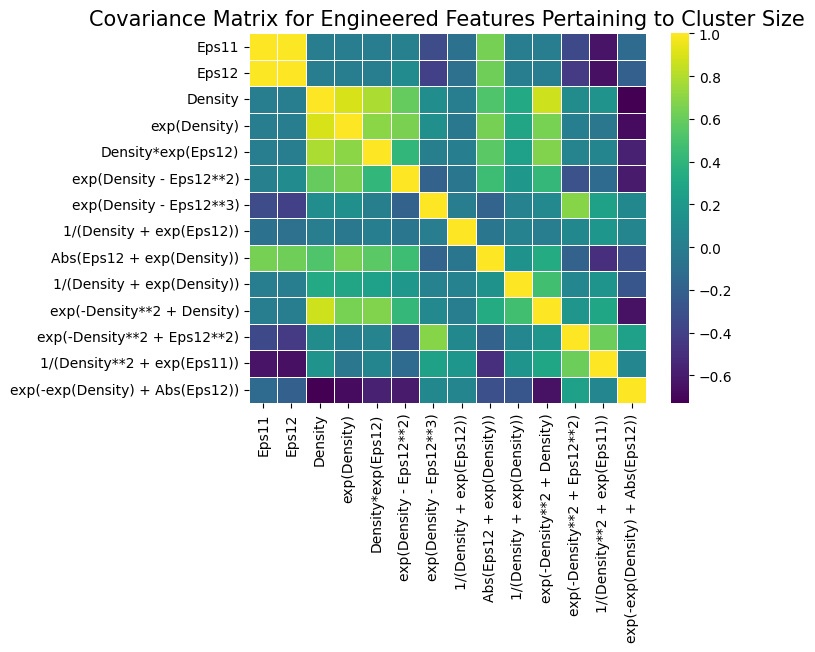

In [288]:
x_new_sc_scaled = x_new_sc.apply(lambda x: (x - x.mean()) / x.std(), axis=0) # standard scale each column of the data frame

sns.heatmap(x_new_sc_scaled.cov(), linewidth=.5, cmap = 'viridis')
plt.title("Covariance Matrix for Engineered Features Pertaining to Cluster Size", fontsize = 15)
plt.show();

For cluster size, 11 new features were generated after implementing three feature engineering steps. Since the initial $r^2$ value without engineered features was already quite high, it appears fewer features needed to be generated, implying that cluster size is most readily predicted with the starting features. This corroborated what was seen when findind the ten largest cluster sizes as the greatest aggregation occurred where $\rho$ was highest. Similarly to the previous covariance matrix,  much isn't revealed in the way of correlations as the features are most related to non-linear combinations of themselves.

In [289]:
x_new_sr = feat_model.fit_transform(x_scaled, sr_scaled) # new set of features for sphere ratio

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/autofeat/featsel.py:270: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  if np.max(np.abs(correlations[c].ravel()[:i])) < 0.9:


In [290]:
r2_newfeat_sr_train= feat_model.score(x_train_r, y_train_r)

r2_newfeat_sr_test= feat_model.score(x_test_r, y_test_r)


print("r^2 Testing Results for new Features regarding sphere ratio:", r2_newfeat_sr_train)
print("r^2 Testing Results for new Features regarding sphere ratio:", r2_newfeat_sr_test)

x_new_sr

r^2 Testing Results for new Features regarding sphere ratio: 0.9857050616185327
r^2 Testing Results for new Features regarding sphere ratio: 0.9816001983150568


Eps11     Eps12   Density  Abs(Density)  Density*Abs(Eps11)  \
0   -1.641107 -1.979896 -2.475387      2.475387           -4.062376   
1   -1.641107 -1.979896 -2.019395      2.019395           -3.314044   
2   -1.641107 -1.979896 -1.563403      1.563403           -2.565711   
3   -1.641107 -1.979896 -1.107410      1.107410           -1.817379   
4   -1.641107 -1.979896 -0.651418      0.651418           -1.069046   
..        ...       ...       ...           ...                 ...   
394  1.641107  1.423858  0.807758      0.807758            1.325617   
395  1.641107  1.423858  0.898956      0.898956            1.475284   
396  1.641107  1.423858  0.990155      0.990155            1.624950   
397  1.641107  1.423858  1.081353      1.081353            1.774617   
398  1.641107  1.423858  1.172552      1.172552            1.924283   

     exp(Density - Eps11)  Abs(Density + Eps12)  exp(Density - Eps12**3)  \
0                0.434187              4.455283               197.507836   
1                0.685033              3.999291               311.615689   
2                1.080804              3.543298               491.648023   
3                1.705225              3.087306               775.691942   
4                2.690399              2.631313              1223.838927   
..                    ...                   ...                      ...   
394              0.434591              2.231616                 0.125064   
395              0.476089              2.322814                 0.137006   
396              0.521549              2.414013                 0.150088   
397              0.571350              2.505211                 0.164419   
398              0.625906              2.596410                 0.180119   

     Abs(Eps12 + Abs(Density))  Abs(Eps11 - exp(Density))  \
0                     0.495492                   1.725238   
1                     0.039499                   1.773843   
2                     0.416493                   1.850530   
3                     0.872486                   1.971521   
4                     1.328478                   2.162413   
..                         ...                        ...   
394                   2.231616                   0.601766   
395                   2.322814                   0.815930   
396                   2.414013                   1.050544   
397                   2.505211                   1.307560   
398                   2.596410                   1.589118   

     exp(-Density**2 + Density)  exp(-Eps12**3 + Abs(Eps11))  \
0                      0.000184                 12115.887002   
1                      0.002249                 12115.887002   
2                      0.018176                 12115.887002   
3                      0.096930                 12115.887002   
4                      0.341038                 12115.887002   
..                          ...                          ...   
394                    1.167991                     0.287774   
395                    1.095087                     0.287774   
396                    1.009796                     0.287774   
397                    0.915787                     0.287774   
398                    0.816829                     0.287774   

     log(Density**2 + exp(Eps11))  log(exp(Density)*Abs(Eps12))  \
0                        1.843926                     -1.792343   
1                        1.452017                     -1.336351   
2                        0.970018                     -0.880358   
3                        0.350743                     -0.424366   
4                       -0.481088                      0.031626   
..                            ...                           ...   
394                      1.760158                      1.161128   
395                      1.786580                      1.252326   
396                      1.815034                      1.343525   
397                      1.845333                      1.434723   
398

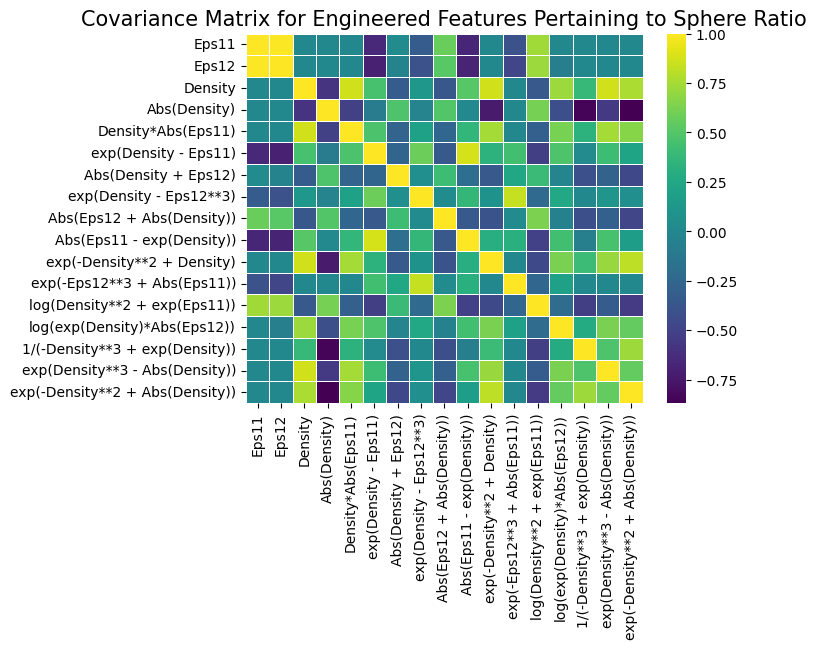

In [291]:
x_new_sr_scaled = x_new_sr.apply(lambda x: (x - x.mean()) / x.std(), axis=0) # standard scale each column of the data frame

sns.heatmap(x_new_sr_scaled.cov(), linewidth=.5, cmap = 'viridis')
plt.title("Covariance Matrix for Engineered Features Pertaining to Sphere Ratio", fontsize = 15)
plt.show();

The sphere ratio feature engineering resulted in 14 new features in line with it having the second largest $r^2$ value, implying a linear model was able to capture its results quite well. Like cluster size, there seemed to be a fairly discernible trend in the correlation between the features and predicting results. Finally, the covariance matrix is moot similar to the previous two.

r^2 Testing Number of Clusters: 0.9818403487831431
r^2 Testing Size of Clusters: 0.9991774837696924
r^2 Testing Percent Spheres: 0.9849179390123387


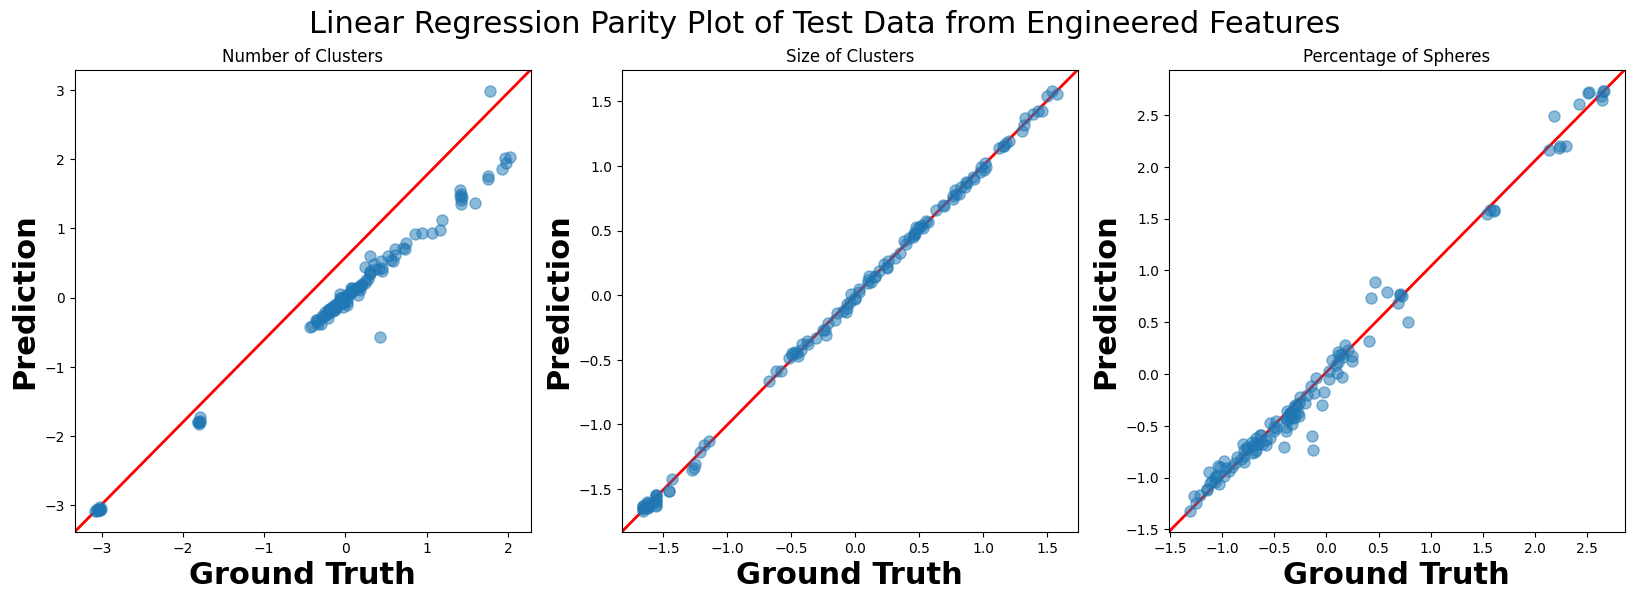

In [292]:
#-------------------------------------------------------------------------------- */
# redo train/test split with data that has engineered features 

x_train_n_new, x_test_n_new, y_train_n_new, y_test_n_new = train_test_split(x_new_nc_scaled, nc_scaled, test_size=0.3)
x_train_s_new, x_test_s_new, y_train_s_new, y_test_s_new = train_test_split(x_new_sc_scaled, sc_scaled, test_size=0.3)
x_train_r_new, x_test_r_new, y_train_r_new, y_test_r_new = train_test_split(x_new_sr_scaled, sr_scaled, test_size=0.3)

linear_model.fit(x_train_n_new, y_train_n_new) # fit the model
yhat_nc_new = linear_model.predict(x_test_n_new) # create the model prediction for all x values
r2_nc_new = linear_model.score(x_test_n_new, y_test_n_new) 

linear_model.fit(x_train_s_new, y_train_s_new) # fit the model
yhat_sc_new = linear_model.predict(x_test_s_new) # create the model prediction for all x values
r2_sc_new = linear_model.score(x_test_s_new, y_test_s_new)

linear_model.fit(x_train_r_new, y_train_r_new) # fit the model
yhat_sr_new = linear_model.predict(x_test_r_new) # create the model prediction for all x values
r2_sr_new = linear_model.score(x_test_r_new, y_test_r_new)

print("r^2 Testing Number of Clusters:", r2_nc_new)
print("r^2 Testing Size of Clusters:", r2_sc_new)
print("r^2 Testing Percent Spheres:", r2_sr_new)

#-------------------------------------------------------------------------------- */
# PLOT

font_axis_publish = {'color':  'black', 'weight': 'bold', 'size': 22}


fig, ax = plt.subplots(1, 3, figsize = (20, 6))

ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot(y_test_n_new, yhat_nc_new, "o", alpha=0.5 , ms=8)
ax[0].set_title("Number of Clusters")
ax[0].set_xlabel('Ground Truth', fontdict=font_axis_publish)
ax[0].set_ylabel('Prediction', fontdict=font_axis_publish)

ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot(y_test_s_new, yhat_sc_new, "o", alpha=0.5 , ms=8)
ax[1].set_title("Size of Clusters")
ax[1].set_xlabel('Ground Truth', fontdict=font_axis_publish)
ax[1].set_ylabel('Prediction', fontdict=font_axis_publish)
fig.suptitle("Linear Regression Parity Plot", fontsize = 22)

ax[2].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[2].transAxes)
ax[2].plot(y_test_r_new, yhat_sr_new, "o", alpha=0.5 , ms=8)
ax[2].set_title("Percentage of Spheres")
ax[2].set_xlabel('Ground Truth', fontdict=font_axis_publish)
ax[2].set_ylabel('Prediction', fontdict=font_axis_publish)
fig.suptitle("Linear Regression Parity Plot of Test Data from Engineered Features", fontsize = 22)
plt.show();

Visual inspection of the parity plot corroborates the story that the $r^2$ tells. Particularly that size is most readily captured by the linear model followed by sphere percentage than the number of clusters. In order to ascertain which features (or combination of features) contribute most to these results, PLSR and LASSO were implemented below.

In [293]:
#-------------------------------------------------------------------------------- */
# Perform PLSR
from sklearn.cross_decomposition import PLSRegression

r2s_plsr_nc = [] # r^2 for number of clusters from PLSR

m_PLS_nc = range(1, x_new_nc_scaled.shape[1]) #PLS does not allow more components than original features

for m in m_PLS_nc:
    model = PLSRegression(n_components = m)
    model.fit(x_train_n_new, y_train_n_new)
    r2 = model.score(x_test_n_new, y_test_n_new)
    r2s_plsr_nc.append(r2)

r2s_plsr_sc = [] # r^2 for cluster size from PLSR

m_PLS_sc = range(1, x_new_sc_scaled.shape[1]) #PLS does not allow more components than original features

for m in m_PLS_sc:
    model = PLSRegression(n_components = m)
    model.fit(x_train_s_new, y_train_s_new)
    r2 = model.score(x_test_s_new, y_test_s_new)
    r2s_plsr_sc.append(r2)    

r2s_plsr_sr = [] # r^2 for sphere ratio from PLSR 

m_PLS_sr = range(1, x_new_sr_scaled.shape[1]) 

for m in m_PLS_sr:
    model = PLSRegression(n_components = m)
    model.fit(x_train_r_new, y_train_r_new)
    r2 = model.score(x_test_r_new, y_test_r_new)
    r2s_plsr_sr.append(r2)    

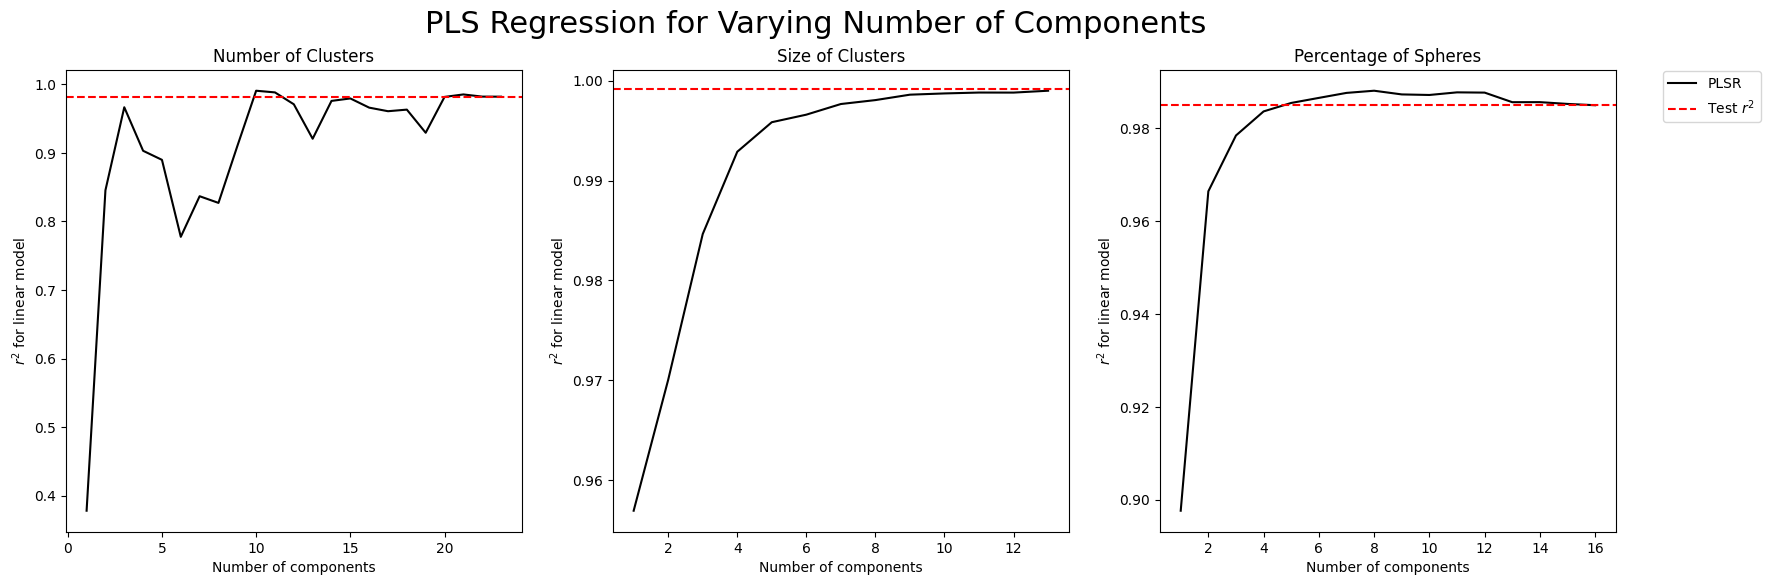

In [318]:
#-------------------------------------------------------------------------------- */
# PLOT
fig, ax = plt.subplots(1, 3, figsize = (20, 6))

ax[0].plot(m_PLS_nc, r2s_plsr_nc, color = 'k', label = 'PLSR')
ax[0].axhline(y = r2_nc_new, color = 'r', linestyle = '--', label = 'Test $r^2$') 
ax[0].set_title("Number of Clusters")
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('$r^2$ for linear model')

ax[1].plot(m_PLS_sc, r2s_plsr_sc, color = 'k')
ax[1].axhline(y = r2_sc_new, color = 'r', linestyle = '--') 
ax[1].set_title("Size of Clusters")
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('$r^2$ for linear model')


ax[2].plot(m_PLS_sr, r2s_plsr_sr, color = 'k')
ax[2].axhline(y = r2_sr_new, color = 'r', linestyle = '--') 
ax[2].set_title("Percentage of Spheres")
ax[2].set_xlabel('Number of components')
ax[2].set_ylabel('$r^2$ for linear model')
fig.suptitle("PLS Regression for Varying Number of Components", fontsize = 22)
fig.legend(loc='center left', bbox_to_anchor=(0.92, 0.835))
plt.show();


The $r^2$ values for the number of clusters deviates from a smooth, asymptotic approach to the maximum $r^2$ value observed. Cluster size most readily follows the expected trend, and the sphere percentage results somehow exceeds the maximum value between 5 and 12 components. Interestingly, the PLSR reveals that the optimal linear combination of features can very closely capture desired results with ~2 sets of parameters for each of the quantities in question. In order to directly see which features are most "valuable," LASSO was performed below.

In [319]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

alphas = np.array([1e-7, 1e-6, 1e-5, 1e-3, 1e-2, 1e-1, 1, 10])

parameter_ranges = {'alpha':alphas}

iter = 10000000

LASSO = Lasso(max_iter = iter)

lasso_search = GridSearchCV(LASSO, parameter_ranges, cv=3)

#-------------------------------------------------------------------------------- */
# LASSO for number of clusters
lasso_search.fit(x_new_nc_scaled, nc_scaled)

print("Best alpha for LASSO number of clusters is:", lasso_search.best_estimator_)

print("Best r^2 for LASSO number of clusters is:", lasso_search.best_score_) # r^2

coeffs =  lasso_search.best_estimator_.coef_

retained = 0
for i in range(len(coeffs)):
    if np.isclose(coeffs, 0, rtol = 1e-04)[i] == False:
        print("Retained Feature", x_new_nc_scaled.columns[i])
        retained += 1
    elif np.isclose(coeffs, 0, rtol = 1e-04)[i] == True:
        print("Removed Feature", x_new_nc_scaled.columns[i])  
print("{} retained features out of {} initial features".format(retained, x_new_nc_scaled.shape[1]))

Best alpha for LASSO number of clusters is: Lasso(alpha=0.001, max_iter=10000000)
Best r^2 for LASSO number of clusters is: 0.9805158947099208
Removed Feature Eps11
Removed Feature Eps12
Retained Feature Density
Retained Feature Density**15
Retained Feature Abs(Density)/Density
Retained Feature exp(-Eps12**2 + Eps12)
Retained Feature Abs(Density + Eps11**2)
Retained Feature exp(-Density**2 + Eps12)
Retained Feature 1/(Density + exp(Eps12))
Retained Feature 1/(Eps12 + exp(Density))
Retained Feature 1/(Density + exp(Eps11))
Retained Feature 1/(Density**3 + 1/Density)
Retained Feature exp(-Eps12**3 + Abs(Eps12))
Retained Feature exp(-Eps12**2 + Abs(Eps11))
Retained Feature exp(-Density**2 + Eps12**2)
Retained Feature 1/(Density**2 + exp(Eps11))
Retained Feature log(Eps11**2 + Abs(Density))
Retained Feature Abs(Eps11**2 - Abs(Density))
Retained Feature 1/(Abs(Density) + 1/Density)
Retained Feature 1/(-Eps11**2 + exp(Density))
Retained Feature Abs(Density**2 - exp(Eps12))
Retained Feature A

In [321]:
#-------------------------------------------------------------------------------- */
# LASSO for size of clusters
lasso_search.fit(x_new_sc_scaled, sc_scaled)

print("Best alpha for LASSO size of clusters is:", lasso_search.best_estimator_)

print("Best r^2 for LASSO size of clusters is:", lasso_search.best_score_) # r^2

coeffs =  lasso_search.best_estimator_.coef_

retained = 0
for i in range(len(coeffs)):
    if np.isclose(coeffs, 0, rtol = 1e-04)[i] == False:
        print("Retained Feature", x_new_sc_scaled.columns[i])
        retained += 1
    elif np.isclose(coeffs, 0, rtol = 1e-04)[i] == True:
         print("Removed Feature", x_new_sc_scaled.columns[i])
print("{} retained features out of {} initial features features".format(retained, x_new_sc_scaled.shape[1]))

Best alpha for LASSO size of clusters is: Lasso(alpha=1e-06, max_iter=10000000)
Best r^2 for LASSO size of clusters is: 0.9962415032153652
Retained Feature Eps11
Retained Feature Eps12
Retained Feature Density
Retained Feature exp(Density)
Retained Feature Density*exp(Eps12)
Retained Feature exp(Density - Eps12**2)
Retained Feature exp(Density - Eps12**3)
Retained Feature 1/(Density + exp(Eps12))
Retained Feature Abs(Eps12 + exp(Density))
Retained Feature 1/(Density + exp(Density))
Retained Feature exp(-Density**2 + Density)
Retained Feature exp(-Density**2 + Eps12**2)
Retained Feature 1/(Density**2 + exp(Eps11))
Retained Feature exp(-exp(Density) + Abs(Eps12))
14 retained features out of 14 initial features features


In [320]:
#-------------------------------------------------------------------------------- */
# LASSO for sphere ratio
lasso_search.fit(x_new_sr_scaled, sr_scaled)

print("Best alpha for LASSO sphere ratio is:", lasso_search.best_estimator_)

print("Best r^2 for LASSO sphere ratio is:", lasso_search.best_score_) # r^2

coeffs =  lasso_search.best_estimator_.coef_

retained = 0
for i in range(len(coeffs)):
    if np.isclose(coeffs, 0, rtol = 1e-04)[i] == False:
        print("Retained Feature", x_new_sr_scaled.columns[i])
        retained += 1
    elif np.isclose(coeffs, 0, rtol = 1e-04)[i] == True:
        print("Removed Feature", x_new_sr_scaled.columns[i])
print("{} retained features out of {} initial features".format(retained, x_new_sr_scaled.shape[1]))

Best alpha for LASSO sphere ratio is: Lasso(alpha=0.001, max_iter=10000000)
Best r^2 for LASSO sphere ratio is: 0.9682467505106632
Removed Feature Eps11
Retained Feature Eps12
Retained Feature Density
Retained Feature Abs(Density)
Retained Feature Density*Abs(Eps11)
Retained Feature exp(Density - Eps11)
Retained Feature Abs(Density + Eps12)
Retained Feature exp(Density - Eps12**3)
Retained Feature Abs(Eps12 + Abs(Density))
Retained Feature Abs(Eps11 - exp(Density))
Retained Feature exp(-Density**2 + Density)
Retained Feature exp(-Eps12**3 + Abs(Eps11))
Removed Feature log(Density**2 + exp(Eps11))
Retained Feature log(exp(Density)*Abs(Eps12))
Retained Feature 1/(-Density**3 + exp(Density))
Retained Feature exp(Density**3 - Abs(Density))
Retained Feature exp(-Density**2 + Abs(Density))
15 retained features out of 17 initial features


In the case of each LASSO optimization coupled with GridSearchCV to find the optimum hyperparameters, very few features were removed with the most being two from cluster number and sphere ratio. Cluster size saw no change which might stand in contrast to PLSR revealing optimal combination can reliably produce a large $r^2$ value even at a low number of considered amalgamations. Perhaps the most odd finding is that in the case of cluster number and sphere ratio, that removed features were $\varepsilon_{1,1}$ and $\varepsilon_{1,2}$ rather than an engineered feature.

For the remainder of the project, more advanced regression techniques were implemented with the first being GPR. 

In [325]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

gpr = GaussianProcessRegressor(kernel=RBF(1), alpha=0.0005)

gpr.fit(x_train_n,y_train_n)

yhat_gpr_nc_unref, yhat_std_nc_unref = gpr.predict(x_test_n, return_std=True)

print("Train r^2 for GPR prediction of cluster number: {}".format(gpr.score(x_train_n, y_train_n)))
print("Test r^2 for GPR prediction of cluster number: {}".format(gpr.score(x_test_n, y_test_n)))

gpr.fit(x_train_s, y_train_s)

yhat_gpr_sc_unref, yhat_std_sc_unref = gpr.predict(x_test_s, return_std=True)

print("Train r^2 for GPR prediction of cluster size: {}".format(gpr.score(x_train_s, y_train_s)))
print("Test r^2 for GPR prediction of cluster size: {}".format(gpr.score(x_test_s, y_test_s)))

gpr.fit(x_train_r, y_train_r)

yhat_gpr_sr_unref, yhat_std_sr_unref = gpr.predict(x_test_r, return_std=True)

print("Train r^2 for GPR prediction of sphere ratio: {}".format(gpr.score(x_train_r, y_train_r)))
print("Train r^2 for GPR prediction of sphere ratio: {}".format(gpr.score(x_test_r, y_test_r)))

Train r^2 for GPR prediction of cluster number: 0.999619916175054
Test r^2 for GPR prediction of cluster number: 0.9981097645546079
Train r^2 for GPR prediction of cluster size: 0.9997078605259493
Test r^2 for GPR prediction of cluster size: 0.9992646752778034
Train r^2 for GPR prediction of sphere ratio: 0.9983523659460897
Train r^2 for GPR prediction of sphere ratio: 0.995773042280409


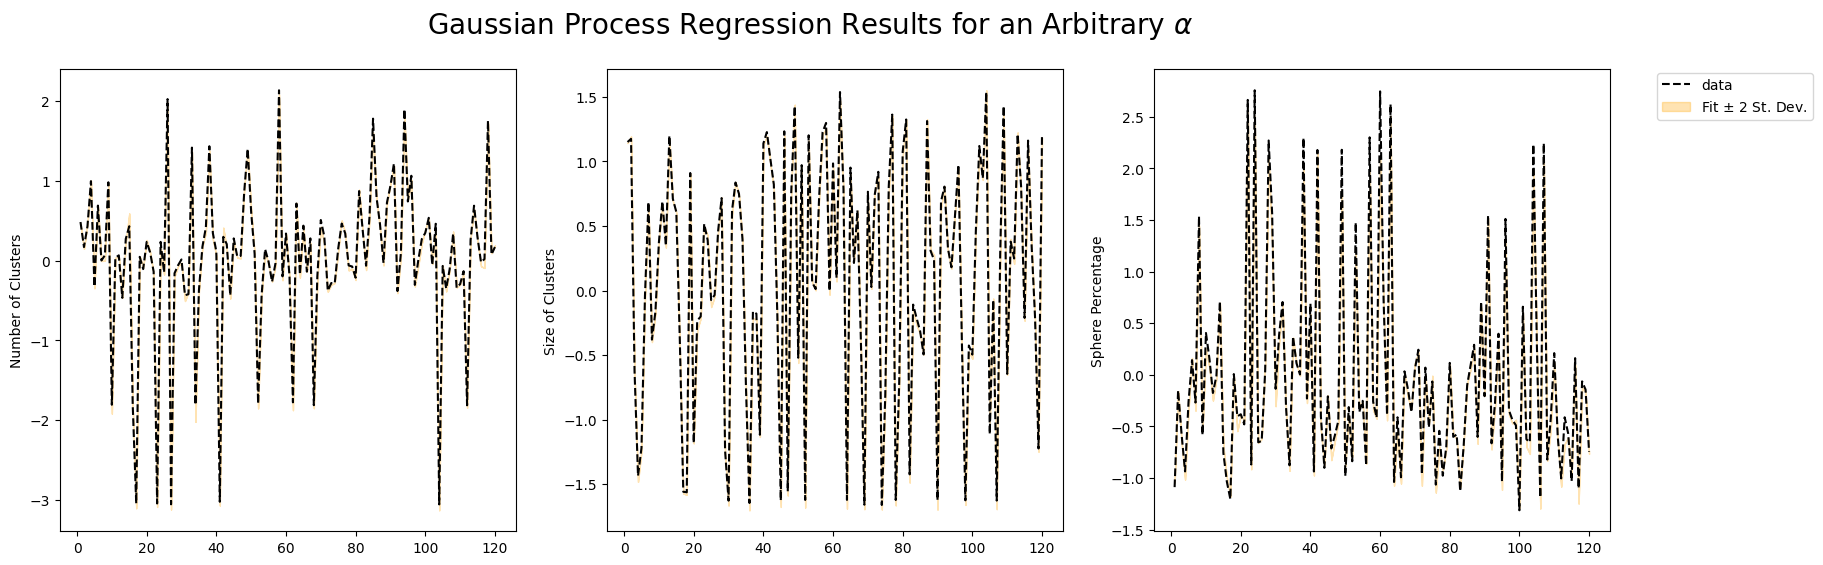

In [326]:
fig, ax = plt.subplots(1, 3, figsize = (20, 6))

ax[0].plot(range(1, len(yhat_gpr_nc_unref)+1), y_test_n, color = 'k', linestyle = '--', label = 'data')
ax[0].fill_between(range(1, len(yhat_gpr_nc_unref)+1), yhat_gpr_nc_unref - 2*yhat_std_nc_unref, yhat_gpr_nc_unref - 2*yhat_std_nc_unref, color='orange', alpha=0.3, label = r'Fit $\pm$ 2 St. Dev.')
ax[0].set_ylabel("Number of Clusters")

ax[1].plot(range(1, len(yhat_gpr_sc_unref)+1), y_test_s, color = 'k', linestyle = '--')
ax[1].fill_between(range(1, len(yhat_gpr_sc_unref)+1), yhat_gpr_sc_unref - 2*yhat_std_sc_unref, yhat_gpr_sc_unref - 2*yhat_std_sc_unref, color='orange', alpha=0.3)
ax[1].set_ylabel("Size of Clusters")

ax[2].plot(range(1, len(yhat_gpr_sr_unref)+1), y_test_r, color = 'k', linestyle = '--')
ax[2].fill_between(range(1, len(yhat_gpr_sr_unref)+1), yhat_gpr_sr_unref - 2*yhat_std_sr_unref, yhat_gpr_sr_unref - 2*yhat_std_sr_unref, color='orange', alpha=0.3)
ax[2].set_ylabel("Sphere Percentage")

fig.suptitle(r"Gaussian Process Regression Results for an Arbitrary $\alpha$", fontsize = 20)
fig.legend(loc='center left', bbox_to_anchor=(0.92, 0.835))
plt.show();

As a respite from parity plots, this figure was chosen since GPR returns standard deviations for the predictions made. We see that even without hyperparemter optimization using GridSearch, the regression technique performs very well. The x-axis is an array made of n-elements incresing in increments of 1 where n $\equiv$ the length of each prediction array. As such, there is no meaning to the domain nor where the error is located. Optimizing the hyperparemters using GridSearch is shown below.

In [300]:
alphas = np.array([1e-7, 1e-6, 1e-5, 1e-3, 1e-2, 1e-1, 1, 10])
parameter_ranges = {'alpha':alphas}

gpr_grid = GridSearchCV(gpr, parameter_ranges, cv = 3)

gpr_grid.fit(x_train_n, y_train_n)

print("Best alpha is:", gpr_grid.best_estimator_)

print("Best r^2 is:", gpr_grid.best_score_) # r^2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warn

Best alpha is: GaussianProcessRegressor(alpha=0.001, kernel=RBF(length_scale=1))
Best r^2 is: 0.9928389585583762


In [301]:
gpr_grid.fit(x_train_s, y_train_s)

print("Best alpha is:", gpr_grid.best_estimator_)

print("Best r^2 is:", gpr_grid.best_score_) # r^2

gpr_grid.score(x_test_s, y_test_s)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warn

Best alpha is: GaussianProcessRegressor(alpha=0.001, kernel=RBF(length_scale=1))
Best r^2 is: 0.9988698447057444


0.999161382985127

In [302]:
gpr_grid.fit(x_train_r, y_train_r)

print("Best alpha is:", gpr_grid.best_estimator_)

print("Best r^2 is:", gpr_grid.best_score_) # r^2

gpr_grid.score(x_test_r, y_test_r)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warn

Best alpha is: GaussianProcessRegressor(alpha=0.01, kernel=RBF(length_scale=1))
Best r^2 is: 0.9919159258538213


0.993998155835065

In [334]:
gpr = GaussianProcessRegressor(kernel=RBF(1), alpha=0.001)

gpr.fit(x_train_n,y_train_n)

yhat_gpr_nc_ref, yhat_std_nc_ref = gpr.predict(x_test_n, return_std=True)

print("Train r^2 for GPR prediction of cluster number: {}".format(gpr.score(x_train_n, y_train_n)))
print("Test r^2 for GPR prediction of cluster number: {}".format(gpr.score(x_test_n, y_test_n)))

gpr = GaussianProcessRegressor(kernel=RBF(1), alpha=0.1)

gpr.fit(x_train_s, y_train_s)

yhat_gpr_sc_ref, yhat_std_sc_ref = gpr.predict(x_test_s, return_std=True)

print("Train r^2 for GPR prediction of cluster size: {}".format(gpr.score(x_train_s, y_train_s)))
print("Test r^2 for GPR prediction of cluster size: {}".format(gpr.score(x_test_s, y_test_s)))

gpr = GaussianProcessRegressor(kernel=RBF(1), alpha=0.01)

gpr.fit(x_train_r, y_train_r)

yhat_gpr_sr_ref, yhat_std_sr_ref = gpr.predict(x_test_r, return_std=True)

print("Train r^2 for GPR prediction of sphere ratio: {}".format(gpr.score(x_train_r, y_train_r)))
print("Train r^2 for GPR prediction of sphere ratio: {}".format(gpr.score(x_test_r, y_test_r)))

Train r^2 for GPR prediction of cluster number: 0.9995168748364099
Test r^2 for GPR prediction of cluster number: 0.9976257123226006
Train r^2 for GPR prediction of cluster size: 0.9936227857490656
Test r^2 for GPR prediction of cluster size: 0.9901303296378329
Train r^2 for GPR prediction of sphere ratio: 0.9965314987941238
Train r^2 for GPR prediction of sphere ratio: 0.9935071022891253


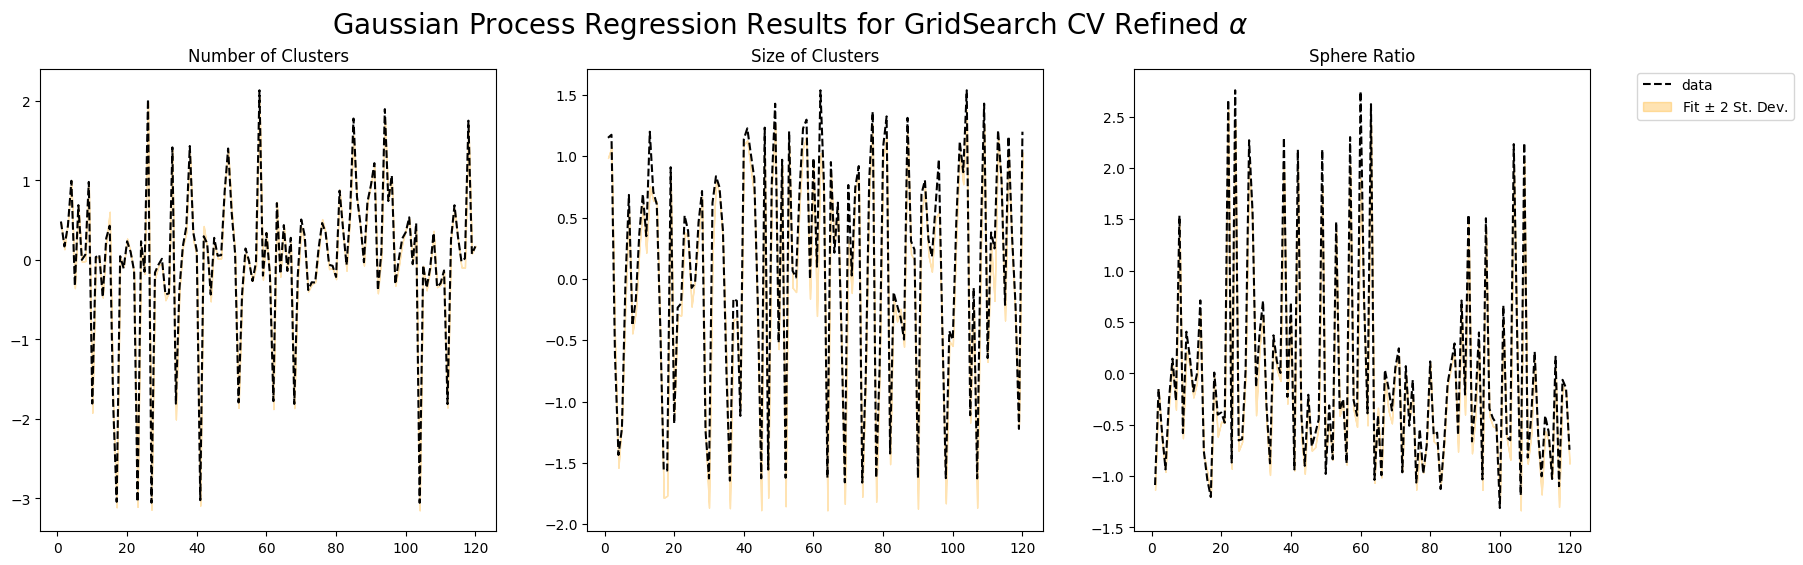

In [335]:
fig, ax = plt.subplots(1, 3, figsize = (20, 6))

ax[0].plot(range(1, len(yhat_gpr_nc_ref)+1), y_test_n, color = 'k', linestyle = '--', label = 'data')
ax[0].fill_between(range(1, len(yhat_gpr_nc_ref)+1), yhat_gpr_nc_ref - 2*yhat_std_nc_ref, yhat_gpr_nc_ref - 2*yhat_std_nc_ref, color='orange', alpha=0.3, label = r'Fit $\pm$ 2 St. Dev.')
ax[0].set_title("Number of Clusters")

ax[1].plot(range(1, len(yhat_gpr_sc_ref)+1), y_test_s, color = 'k', linestyle = '--')
ax[1].fill_between(range(1, len(yhat_gpr_sc_ref)+1), yhat_gpr_sc_ref - 2*yhat_std_sc_ref, yhat_gpr_sc_ref - 2*yhat_std_sc_ref, color='orange', alpha=0.3)
ax[1].set_title("Size of Clusters")

ax[2].plot(range(1, len(yhat_gpr_sr_ref)+1), y_test_r, color = 'k', linestyle = '--')
ax[2].fill_between(range(1, len(yhat_gpr_sr_ref)+1), yhat_gpr_sr_ref - 2*yhat_std_sr_ref, yhat_gpr_sr_ref - 2*yhat_std_sr_ref, color='orange', alpha=0.3)
ax[2].set_title("Sphere Ratio")

fig.suptitle(r"Gaussian Process Regression Results for GridSearch CV Refined $\alpha$", fontsize = 20)
fig.legend(loc='center left', bbox_to_anchor=(0.92, 0.835))
plt.show();

There does not appear to be an appreciable change in the $r^2$ value upon implementing LASSO, though the variation of the prediction is much more prominent. Nonetheless, the data falls within two standard deviations of the model, appearing to capture the behavior of each output in question well. Interestingly, cluster size appears to have the largest standard deviation for the prediction belying previous results of it being the output that was most readily captured. This trend was followed by sphere ratio which appears to have the second largest standard deviation and cluster number having the smallest variation, overturning previous results.

For a final comparison of regression techniques, KRR was used.

r^2 for Number Train Data: 0.9996723982110638
r^2 for Number Test Data: 0.9967144751518268

r^2 for Size Train Data: 0.9998282987092946
r^2 for Size Test Data: 0.999297148131604

r^2 for Sphere Percent Train Data: 0.9984208074906641
r^2 for Sphere Percent Test Data: 0.9952169352641115


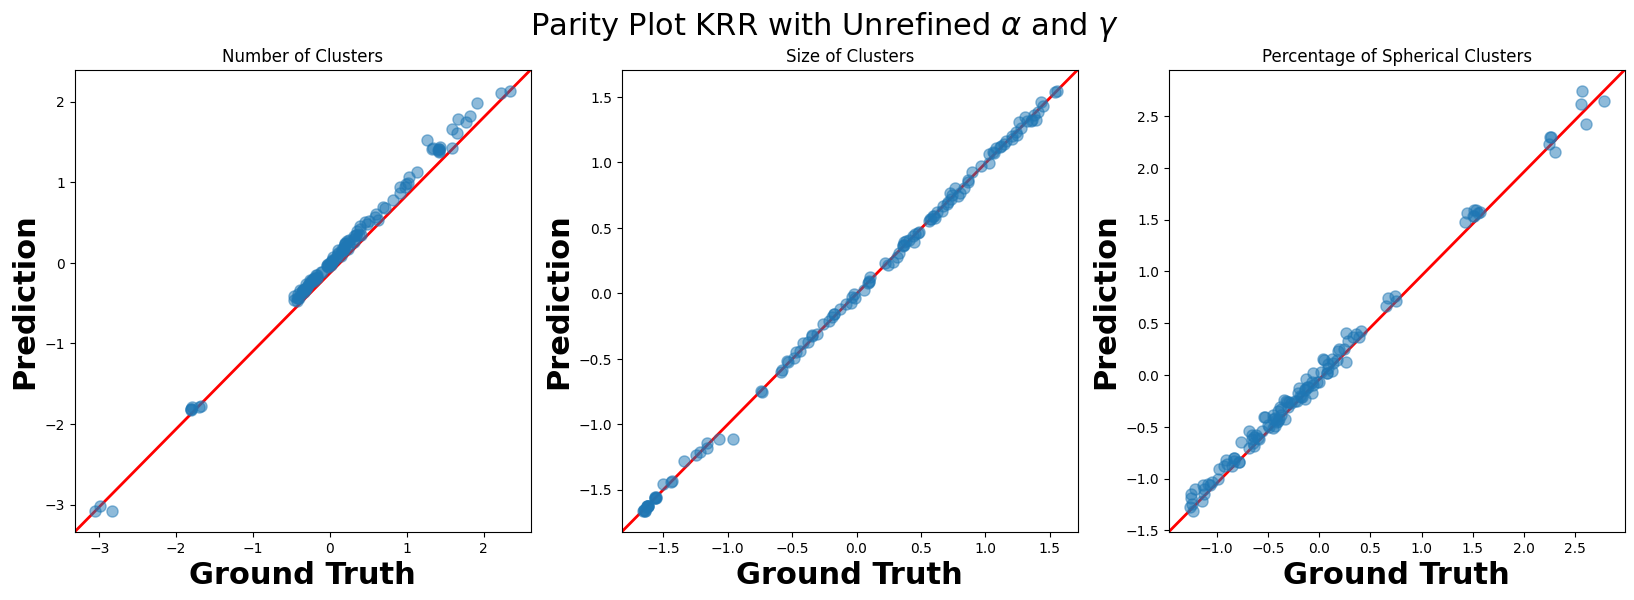

In [305]:
from sklearn.kernel_ridge import KernelRidge

gamma = 1

alpha = 0.0001

KRR = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)

KRR.fit(x_train_n, y_train_n)

print("r^2 for Number Train Data:", KRR.score(x_train_n, y_train_n))
print("r^2 for Number Test Data:", KRR.score(x_test_n, y_test_n))

yhat_krr_nc_unref = KRR.predict(x_test_n)

KRR.fit(x_train_s, y_train_s)

print("\nr^2 for Size Train Data:", KRR.score(x_train_s, y_train_s))
print("r^2 for Size Test Data:", KRR.score(x_test_s, y_test_s))


yhat_krr_sc_unref = KRR.predict(x_test_s)

KRR.fit(x_train_r, y_train_r)

print("\nr^2 for Sphere Percent Train Data:", KRR.score(x_train_r, y_train_r))
print("r^2 for Sphere Percent Test Data:", KRR.score(x_test_r, y_test_r))


yhat_krr_sr_unref = KRR.predict(x_test_r)


fig, ax = plt.subplots(1, 3, figsize = (20, 6))

ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
# ax[0].plot(x, y1, "o", alpha=0.5 , ms=8)
ax[0].plot(yhat_krr_nc_unref, y_test_n, "o", alpha=0.5 , ms=8)
ax[0].set_title("Number of Clusters")
ax[0].set_xlabel('Ground Truth', fontdict=font_axis_publish)
ax[0].set_ylabel('Prediction', fontdict=font_axis_publish)

ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot(yhat_krr_sc_unref, y_test_s, "o", alpha=0.5 , ms=8)
ax[1].set_title("Size of Clusters")
ax[1].set_xlabel('Ground Truth', fontdict=font_axis_publish)
ax[1].set_ylabel('Prediction', fontdict=font_axis_publish)
fig.suptitle("KRR Parity Plot for Testing Set", fontsize = 22)

ax[2].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[2].transAxes)
ax[2].plot(yhat_krr_sr_unref, y_test_r, "o", alpha=0.5 , ms=8)
ax[2].set_title("Percentage of Spherical Clusters")
ax[2].set_xlabel('Ground Truth', fontdict=font_axis_publish)
ax[2].set_ylabel('Prediction', fontdict=font_axis_publish)
fig.suptitle(r"Parity Plot KRR with Unrefined $\alpha$ and $\gamma$", fontsize = 22)
plt.show();

Similar to GPR, KRR even with unrefined parameters performs marvelously. Comparing training and testing $r^2$ values also indicates that overfitting does not appear to be present here. Following suit of GPR, GridSearch was implemented in order to optimize hyperparameters.

In [306]:
params = {
    'alpha': np.array([1e-9, 1e-8, 1e-7 , 1e-6, 1e-4, 1e-2, 1e-1]),
    'gamma': [0.001, 0.01, 0.1, 1, 10, 20, 50],
}

krr_search = GridSearchCV(KRR, param_grid=params, cv=3).fit(x_train_n, y_train_n) 

print("Refined KRR Parameters for Cluster Number: {}".format(krr_search.best_params_))

krr_search = GridSearchCV(KRR, param_grid=params, cv=3).fit(x_train_s, y_train_s) 

print("\nRefined KRR Parameters for Cluster Size: {}".format(krr_search.best_params_))

krr_search = GridSearchCV(KRR, param_grid=params, cv=3).fit(x_train_r, y_train_r) 

print("\nRefined KRR Parameters for Sphere Ratio: {}".format(krr_search.best_params_))


Refined KRR Parameters for Cluster Number: {'alpha': 0.0001, 'gamma': 1}

Refined KRR Parameters for Cluster Size: {'alpha': 0.0001, 'gamma': 1}

Refined KRR Parameters for Sphere Ratio: {'alpha': 0.01, 'gamma': 1}


r^2 for Refined Cluster Number Train Data: 0.9996723982110638
r^2 for Refined Cluster Number Test Data: 0.9967144751518268

r^2 for Refined Cluster Number Train Data: 0.9982485982402626
r^2 for Refined Cluster Number Test Data: 0.9979344960068942

r^2 for Refined Sphere Ratio Train Data: 0.9977604017006311
r^2 for Refined Sphere Ratio Test Data: 0.9944931321585108


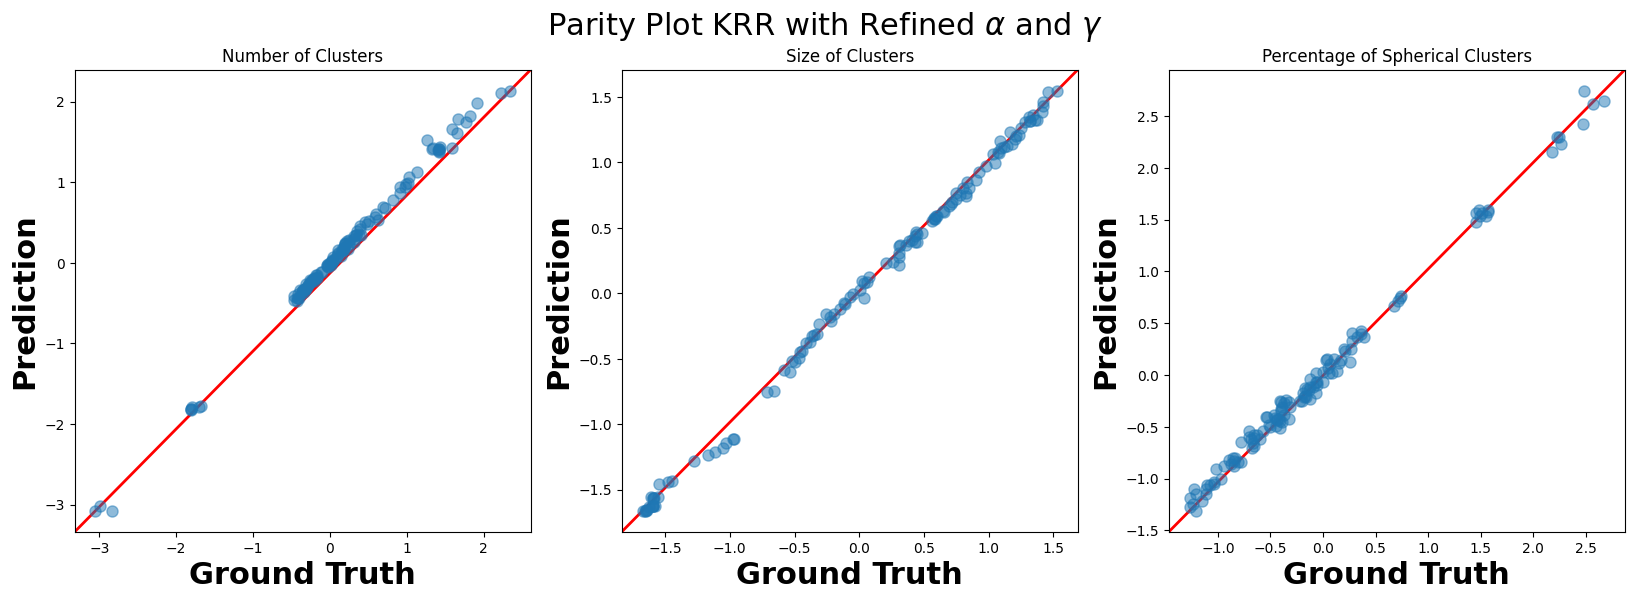

In [308]:
#-------------------------------------------------------------------------------- */
# KRR for Cluster Number
gamma = 1

alpha = 0.0001

KRR = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma).fit(x_train_n, y_train_n)

print("r^2 for Refined Cluster Number Train Data:", KRR.score(x_train_n, y_train_n))
print("r^2 for Refined Cluster Number Test Data:", KRR.score(x_test_n, y_test_n))

yhat_krr_nc_ref = KRR.predict(x_test_n)

#-------------------------------------------------------------------------------- */
# KRR for Cluster Size
gamma = 0.1

alpha = 0.0001

KRR = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma).fit(x_train_s, y_train_s)

print("\nr^2 for Refined Cluster Number Train Data:", KRR.score(x_train_s, y_train_s))
print("r^2 for Refined Cluster Number Test Data:", KRR.score(x_test_s, y_test_s))

yhat_krr_sc_ref = KRR.predict(x_test_s)

#-------------------------------------------------------------------------------- */
# KRR for Cluster Size
gamma = 1

alpha = 0.01

KRR = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma).fit(x_train_r, y_train_r)

print("\nr^2 for Refined Sphere Ratio Train Data:", KRR.score(x_train_r, y_train_r))
print("r^2 for Refined Sphere Ratio Test Data:", KRR.score(x_test_r, y_test_r))

yhat_krr_sr_ref = KRR.predict(x_test_r)

#-------------------------------------------------------------------------------- */
# Parity Plots

fig, ax = plt.subplots(1, 3, figsize = (20, 6))

ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot(yhat_krr_nc_ref, y_test_n, "o", alpha=0.5 , ms=8)
ax[0].set_title("Number of Clusters")
ax[0].set_xlabel('Ground Truth', fontdict=font_axis_publish)
ax[0].set_ylabel('Prediction', fontdict=font_axis_publish)

ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot(yhat_krr_sc_ref, y_test_s, "o", alpha=0.5 , ms=8)
ax[1].set_title("Size of Clusters")
ax[1].set_xlabel('Ground Truth', fontdict=font_axis_publish)
ax[1].set_ylabel('Prediction', fontdict=font_axis_publish)
fig.suptitle("KRR Parity Plot for Testing Set", fontsize = 22)

ax[2].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[2].transAxes)
ax[2].plot(yhat_krr_sr_ref, y_test_r, "o", alpha=0.5 , ms=8)
ax[2].set_title("Percentage of Spherical Clusters")
ax[2].set_xlabel('Ground Truth', fontdict=font_axis_publish)
ax[2].set_ylabel('Prediction', fontdict=font_axis_publish)
fig.suptitle(r"Parity Plot KRR with Refined $\alpha$ and $\gamma$", fontsize = 22)
plt.show();


Once again, hyperparameter optimization appears to be moot as the $r^2$ values don't change appreciably. The positive aspect of this, however, is that both KRR and GPR are effective in capturing the behavior of the system. As a final avenue of exploration, a simple classification scheme was implemented to see if a system was highly spherical (> 75% sphere:non-sphere) or not using decision tree, kNN, and SVM whose hyperparameters were tuned using GridSearch.

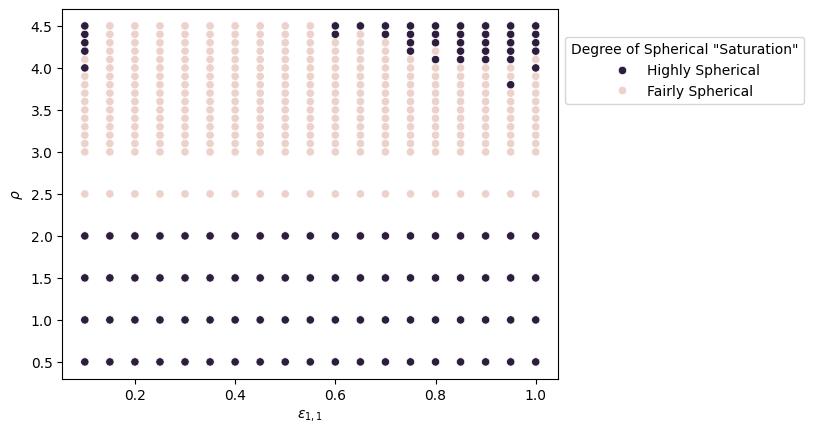

Eps11     Eps12  Density  Number of Clusters  Size of Clusters  \
0      0.1  0.316228      0.5               46.76          2.152866   
1      0.1  0.316228      1.0              259.08          2.342503   
2      0.1  0.316228      1.5              565.04          2.684892   
3      0.1  0.316228      2.0              792.72          3.390144   
4      0.1  0.316228      2.5              816.04          4.922587   
..     ...       ...      ...                 ...               ...   
394    1.0  1.000000      4.1              504.84         16.052488   
395    1.0  1.000000      4.2              503.04         16.502475   
396    1.0  1.000000      4.3              499.32         17.091991   
397    1.0  1.000000      4.4              494.44         17.629145   
398    1.0  1.000000      4.5              489.04         18.193521   

     Sphere Percent  
0               1.0  
1               1.0  
2               1.0  
3               1.0  
4              -1.0  
..              ...  
394            -1.0  
395             1.0  
396             1.0  
397             1.0  
398             1.0  

[399 rows x 6 columns]

In [524]:
#-------------------------------------------------------------------------------- */
# Create copy of dataframe and make last column -1 or 1 depending on criteria 

filtered_df = df.copy(deep=True)

filtered_df.loc[filtered_df['Sphere Percent'] >= 0.75, 'Sphere Percent'] = 1
filtered_df.loc[filtered_df['Sphere Percent'] != 1, 'Sphere Percent'] = -1

sns.scatterplot(data = filtered_df, x = filtered_df.iloc[:, 0], y = filtered_df.iloc[:, 2], hue = filtered_df.iloc[:, -1])
plt.xlabel(r'$\varepsilon_{1,1}$')
plt.ylabel(r'$\rho$')
plt.legend(title='Degree of Spherical "Saturation"', labels=['Highly Spherical', 'Fairly Spherical'], loc='center left', bbox_to_anchor=(1.0, 0.835))
plt.show();

filtered_df

In [511]:
#-------------------------------------------------------------------------------- */
# Create train/test splits

x_class = np.array(filtered_df.iloc[:, 0:3])
x_rho = np.array(filtered_df.iloc[:, 2])
y_class = np.array(filtered_df.iloc[:, -1])

X_train, X_test, y_train, y_test = train_test_split(x_class, y_class, test_size=0.30) # 30% testing data

X_train_rho, X_test_rho, y_train_rho, y_test_rho = train_test_split(x_rho, y_class, test_size=0.30) # 30% testing data


In [514]:
#-------------------------------------------------------------------------------- */
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

max_depths = np.arange(1, 11, 1)
parameter_ranges = {'max_depth':max_depths}

dtree = DecisionTreeClassifier()
tree_search = GridSearchCV(dtree, parameter_ranges, cv=3)
tree_search.fit(X_train_rho.reshape(-1, 1), y_train_rho.reshape(-1, 1))


print("Best Max Depth for Density:", tree_search.best_estimator_)
print("Density Accuracy:", tree_search.score(X_test_rho.reshape(-1, 1), y_test_rho.reshape(-1, 1)))

tree_search = GridSearchCV(dtree, parameter_ranges, cv=3)
tree_search.fit(X_train, y_train)

print("\nBest Max Depth for All Features:", tree_search.best_estimator_)
print("Accuracy for All Features:", tree_search.score(X_test,y_test))

Best Max Depth for Density: DecisionTreeClassifier(max_depth=3)
Density Accuracy: 0.8833333333333333

Best Max Depth for All Features: DecisionTreeClassifier(max_depth=7)
Accuracy for All Features: 0.9583333333333334


Tree Accuracy: 0.8833333333333333


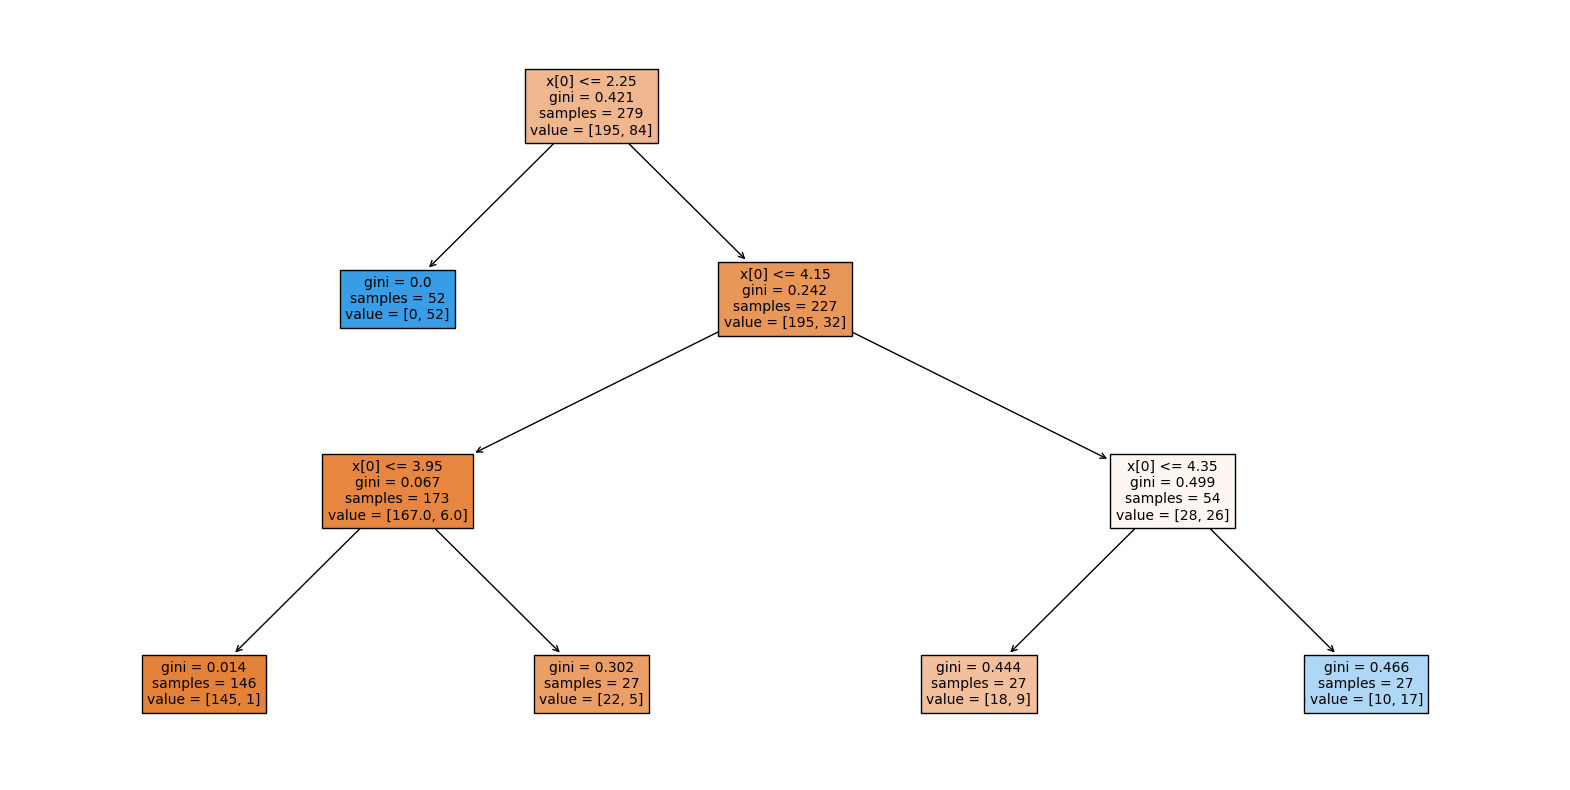

In [518]:
dtree=DecisionTreeClassifier(max_depth=3) # max depth from GridSearch
dtree.fit(X_train_rho.reshape(-1, 1), y_train_rho.reshape(-1, 1))
#-------------------------------------------------------------------------------- */
# Plot the tree
plt.figure(figsize=(20,10))
tree.plot_tree(dtree, filled=True, fontsize=10);

print("Tree Accuracy:", dtree.score(X_test_rho.reshape(-1, 1), y_test_rho.reshape(-1, 1)))
rho_tree_pred = dtree.predict(X_test_rho.reshape(-1, 1))

Tree Accuracy: 0.9583333333333334


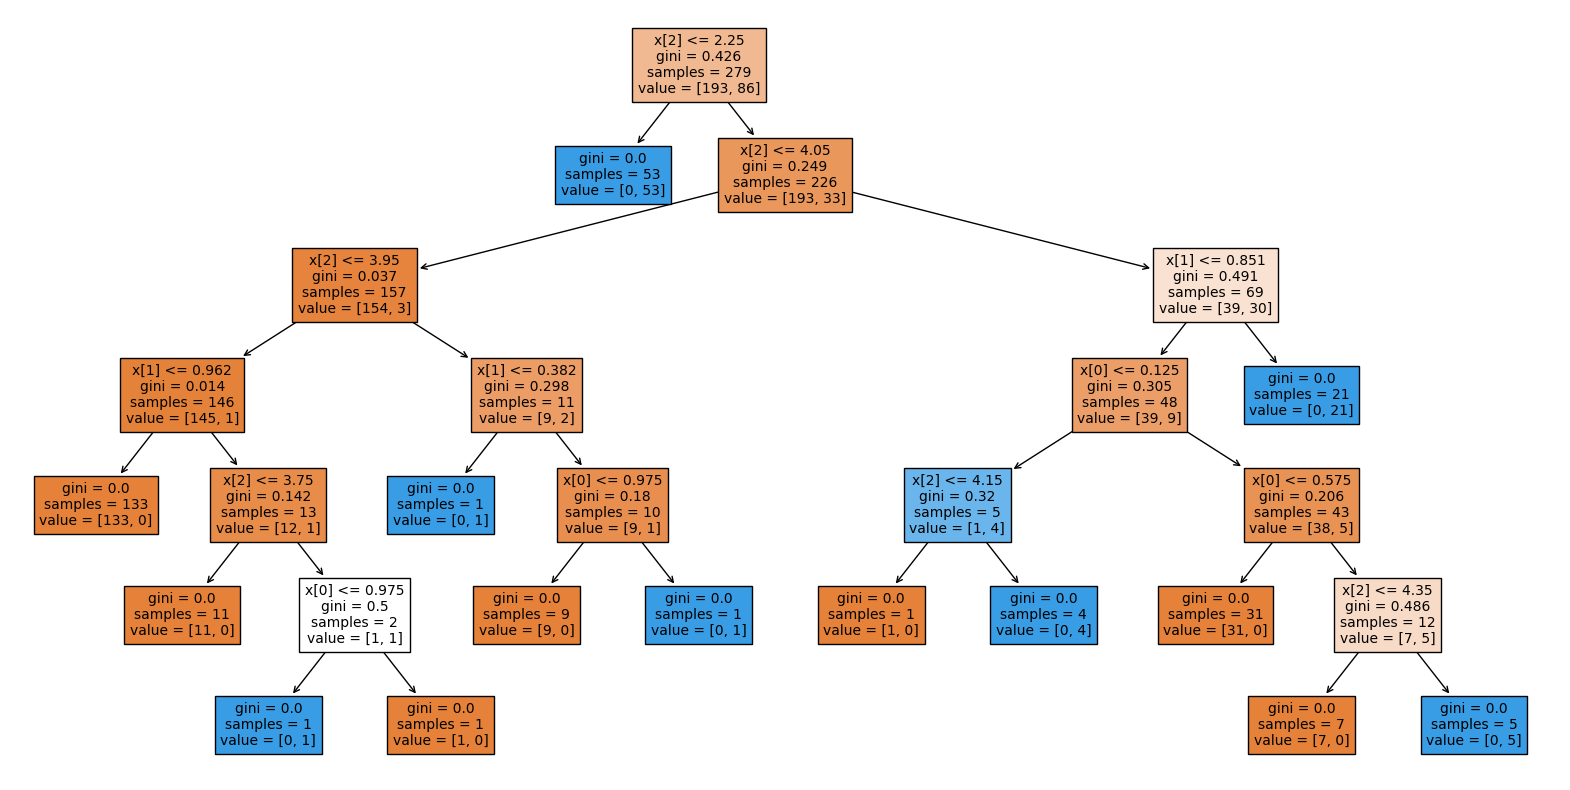

In [520]:
dtree=DecisionTreeClassifier(max_depth=7) # max depth from GridSearch
dtree.fit(X_train, y_train)
#-------------------------------------------------------------------------------- */
# Plot the tree
plt.figure(figsize=(20,10))
tree.plot_tree(dtree, filled=True, fontsize=10);

print("Tree Accuracy:", dtree.score(X_test, y_test))
all_tree_pred = dtree.predict(X_test)

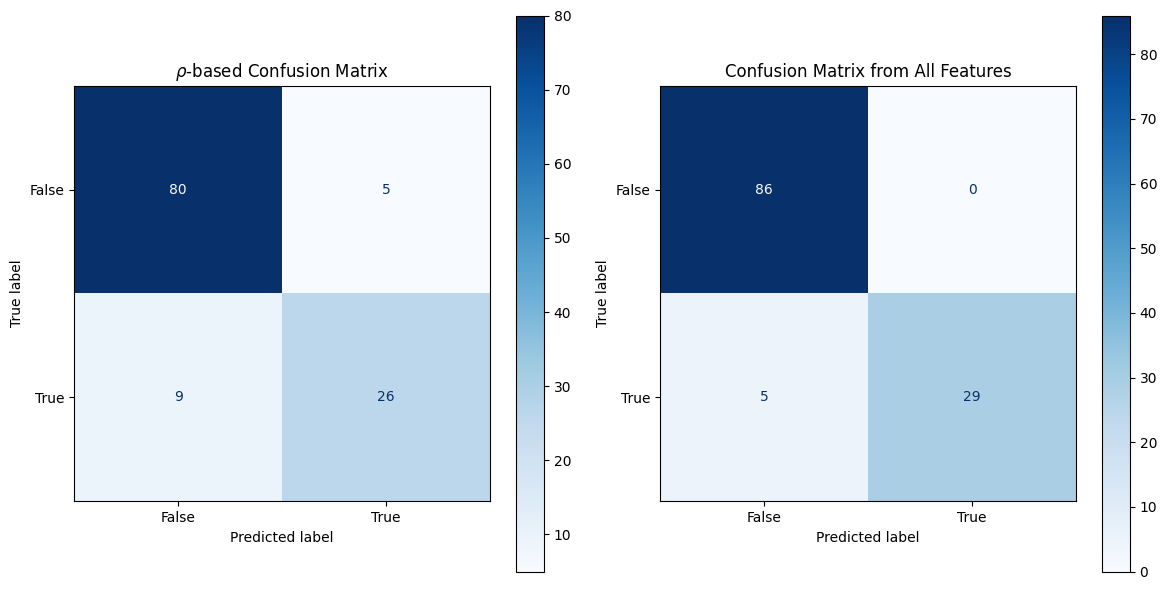

In [522]:
from sklearn import metrics

confusion_matrix_rho = metrics.confusion_matrix(rho_tree_pred, y_test_rho)
confusion_matrix_all = metrics.confusion_matrix(all_tree_pred, y_test)

cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix_rho, display_labels=[False, True])
cm_display2 = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_all, display_labels=[False, True])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # Create subplots with 1 row and 2 columns

# Plot the first confusion matrix on the left subplot
cm_display1.plot(ax=ax[0], cmap=plt.cm.Blues)
ax[0].set_title(r'$\rho$-based Confusion Matrix')

# Plot the second confusion matrix on the right subplot
cm_display2.plot(ax=ax[1], cmap=plt.cm.Blues)
ax[1].set_title('Confusion Matrix from All Features')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Given the results from the LASSO search, I was curious to see how well the density values could predict the ratio of "sphericity" for a given set of parameters. Comparing the accuracy of the density-based classification system to all features, the two are quite close. When inspecting the decision tree that considers all features, the highest gini values are associated with `x[2]` corresponding to density, corroborating the notion that it is the parameter holding the most weight for classification.

In [523]:
#-------------------------------------------------------------------------------- */
# Average over i loops to find most accurate model

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

i = 20

tree_acc = np.zeros(i)
knn_acc = np.zeros(i)
svm_acc = np.zeros(i)


for j in range(i):
    X_train, X_test, y_train, y_test = train_test_split(x_class, y_class, test_size=0.30) # 30% testing data; re-split each loop
    max_depths = np.arange(1, 11, 1)
    parameter_ranges = {'max_depth':max_depths}

    dtree = DecisionTreeClassifier()
    tree_search = GridSearchCV(dtree, parameter_ranges, cv=3)
    tree_search.fit(X_train, y_train)

    tree_acc[j] = tree_search.score(X_test,y_test)

    ks = np.arange(1, 11, 1)
    parameter_ranges = {'n_neighbors':ks}

    knn = KNeighborsClassifier()
    knn_search = GridSearchCV(knn, parameter_ranges, cv=3)
    knn_search.fit(X_train, y_train)

    knn_acc[j] = knn_search.score(X_test,y_test)

    sigmas = np.array([0.001, 0.1, 1, 10, 100])
    gammas = 1./(2*sigmas**2)

    alphas = np.array([1e-9, 1e-5, 1e-4,1e-3, 1e-2,1e-1, 1])
    Cs = 1/alphas

    parameter_ranges = {'C':Cs, 'gamma':gammas}

    svc = SVC(kernel='rbf')

    svc_search = GridSearchCV(svc, parameter_ranges, cv=3)
    svc_search.fit(X_train,y_train)
    svm_acc[j] = svc_search.score(X_test,y_test)
    
print("Average Tree Accuracy:", np.mean(tree_acc))
print("Average kNN Accuracy:", np.mean(knn_acc))
print("Average SVM Accuracy:", np.mean(svm_acc))

Average Tree Accuracy: 0.9583333333333334
Average kNN Accuracy: 0.9604166666666666
Average SVM Accuracy: 0.9583333333333333


In the end, each classication model worked well for the task at hand. It seems like kNN was most effective, though each method performed very well. In the scope of identifying which feature was most useful for the job of classification, decision tree with the Gini index was paramount in facilitating further understanding of the system at hand.

## Conclusions: (15 points)

* Compare your results to other models on the same data in the literature or on websites. (optional)
* State your conclusions based on the results.  Relate back to the goal you posed in the introduction. (10)
* Given more time or data what would you try next to improve your model(s), or if it already works well how would you extend it to other datasets? (5)

Between each regression model that was trained, the $r^2$ values from training sets while implementing the same train/test ratio were comparable to each other. Although linear regression initially lagged behind, it was able to make up for the lack of information through feature engineering, creating non-linear combinations of the three input parameters that were initially present. KRR and GPR performed just as well without using the feature engineered values, and the two only requried subtle optimization through GridSearch. Besides the efficacy of the "advanced" regression models, the salient results of this project to me were that the energetic scales appear to be less important in predicting outcomes than density. This can be rationalized when considering that only the GEM-4 particles account for the phenomena of interest, and they are only affected by the density of the system. 

Similar results held true for the classification problem I divised. Each model performed well with accuracy values on the testing data above 0.95. Seeing the results of the LASSO implementation, I singled out density to use as the sole feature for prediction in the case of decision tree, and it performed similarly with an accuracy of 0.88. Inspecting the tree made by considering all features showed the highest Gini value for density, corroborating its place as the most important feature to consider.

Given these results, I'd say my goal of better understanding the system was met fairly well. Each model, whether regression or classification, was able to reliably produce accurate results regardless of what that metric looked like. In particular, LASSO and the decision tree shed light on what the models presumably saw as the most useful feature for predictions which intuitivelty made sense as well. For future directions, it would be interesting to vary the $\varepsilon_{2,2}$ values to see how that might change the results as I imagine density played the biggest role due to it being the only factor corresponding to the GEM-4 species. Furthermore, I think varying the dimer bond length and temperature of the system could produce varying results and further elucidate the dynamics of the system. Lastly, the small size of the feature set and outputs leads me to believe overfitting could be a potential issue. To this end, I'd like to implement BIC or something more versatile to the regression models and something analagous for classification to ensure the robustness of the results more than comparing the $r^2$ value of a train/test split.

## References <a class="anchor" id="ref"></a>

[1] Rev. Mod. Phys. 88, 045006 (2016), "Active Particles in Complex and Crowded Environments"

[2] https://www.ovito.org/manual/reference/pipelines/modifiers/cluster_analysis.html

[3]  J. Chem. Phys. 138, 054904 (2013); doi: 10.1063/1.4788616 "Gyration tensor based analysis of the shapes of polymer chains in an attractive spherical cage"
